# U-Net for Image Segmentation in ACCORDs Project

This notebook demonstrates the implementation, training, and evaluation of a **U-Net neural network** for image segmentation.  
The work is part of the **ACCORDs project**, which focuses on analyzing TEM images of graphene-based materials.  

## 📌 Why U-Net?
U-Net was originally introduced in 2015 for **biomedical image segmentation**. It quickly became a standard architecture because it works well even when:
- Training datasets are relatively small,  
- Fine details at the pixel level matter,  
- Boundaries between different regions must be precisely captured.  

These characteristics make U-Net an excellent candidate for segmenting **graphene structures in TEM images**, where clear boundaries and small-scale details are essential.

## 🔧 Key Ideas
- **Encoder (Contracting Path):** progressively reduces the spatial size of the image while capturing semantic (high-level) information.  
- **Decoder (Expanding Path):** reconstructs the segmentation mask, step by step, until it has the same size as the input image.  
- **Skip Connections:** directly connect encoder and decoder layers at the same level. This helps the model combine high-level context with fine-grained local details, which is crucial for accurately segmenting thin and complex structures.

## 📂 What this notebook covers
1. Data preparation (images and masks).  
2. Implementation of the U-Net model in PyTorch.  
3. Training procedure, including loss functions and optimizers.  
4. Evaluation using segmentation metrics (Dice, IoU).  
5. Visualization of predictions vs. ground truth masks.  
6. A report-style summary at the end.  




## 1) Environment & Global Config (Vertex AI)

**Actions**
- Installs the Python packages needed for training and evaluation:
  - `torch`, `torchvision` – core deep-learning stack (PyTorch).
  - `segmentation-models-pytorch` – ready-made segmentation architectures with modern backbones (ResNet/EfficientNet/FPN/DeepLab).
  - `albumentations`, `opencv-python` – fast image augmentations and I/O.
  - `scikit-learn` – utilities for metrics/splits.
  - `matplotlib` – plotting.
  - `gcsfs` – read/write directly to Google Cloud Storage from the notebook.
- Imports `gcsfs` and `os` for GCS access and path handling.
- Sets **random seeds** (`torch`, `numpy`, `random`) to make runs as reproducible as possible.
- Fixes cuDNN behavior:
  - `deterministic=True` forces deterministic kernels (same results run-to-run),
  - `benchmark=False` avoids auto-tuning that could change computations between runs.
- Defines **global training hyperparameters** in one place.

**Explanation**
- Deep learning pipelines depend on many libraries; installing them upfront prevents version drift across sessions.
- Reproducibility in DL is non-trivial (GPU kernels can be nondeterministic). Setting seeds + deterministic cuDNN narrows variability, which is important when you compare models or debug.
- Centralizing hyperparameters (image size, batch size, learning rate, epoch count, validation/test split) makes the notebook easier to control like an experiment script.

**Key knobs**
- `IMG_SIZE=(512, 512)`: all images/masks are resized/cropped to this resolution for training.
- `NUM_CLASSES=3`: we currently model three channels (GFM, carbonhole, undefined). Some training stages may collapse to 2 channels (e.g., GFM/CH) for loss design—keeping the global here documents the dataset’s full labeling scheme.
- `BATCH_SIZE=4`: trade-off between GPU memory and gradient quality.
- `EPOCHS=50`: upper bound; early stopping may finish earlier.
- `LEARNING_RATE=1e-3`: initial step size for the optimizer.
- `VAL_SPLIT`, `TEST_SPLIT`: fractions for validation/test partitions when we split the dataset.

> ℹ️ On Vertex AI Workbench, `gcsfs` lets us stream data from `gs://…` paths directly, so we don’t need to download whole datasets to local disk.


In [1]:
# === Vertex AI Setup ===
!pip install --upgrade pip
!pip install torch torchvision segmentation-models-pytorch albumentations opencv-python scikit-learn matplotlib gcsfs

import gcsfs
import os

import torch, numpy as np, random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ✅ Global training parameters
IMG_SIZE = (512, 512)        # Resize or crop to this size
NUM_CLASSES = 3              # GFM, carbonhole, undefined
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-3
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

## 2) GCS: Paths and Image–Mask Pairing

**Actions**
- Defines dataset directories inside the Google Cloud Storage (GCS) bucket:
  - `IMAGE_DIR`: contains input `.png` images.
  - `MASK_DIR`: contains corresponding `.npz` masks.
- Scans both directories with `gcsfs` and collects all file paths.
- Extracts basenames (filenames without extensions).
- Builds lookup maps (basename → full path).
- Compares sets of image vs. mask basenames to:
  - Detect missing masks or missing images.
  - Keep only properly matched pairs.
- Produces final lists: `MATCHED_IMAGE_PATHS` and `MATCHED_MASK_PATHS`.
- Prints diagnostic information (counts, missing entries, and sample matches).
- Raises an error if no matched pairs are found.

**Input**
- Files in GCS under:
  - `gs://accords-data/training_data/Batch_1/Batch_1/masks_output_pipe/net_input_images/*.png`
  - `gs://accords-data/training_data/Batch_1/Batch_1/masks_output_pipe/net_input_masks/*.npz`

**Output**
- Two Python lists of equal length:
  - `MATCHED_IMAGE_PATHS` (paths to `.png` images).
  - `MATCHED_MASK_PATHS` (paths to corresponding `.npz` masks).
- Console report showing:
  - Number of matched pairs.
  - Any missing masks/images.
  - Example matches for quick inspection.

**Explanation**
Segmentation requires **paired input–output data**: each raw image must have a matching ground-truth mask.  
Without this strict 1-to-1 pairing, the model would either train incorrectly or fail.  
This step acts like a **consistency check** in experimental physics: making sure each detector event has both the measured signal and the calibration reference.  
By doing this upfront, we avoid training on incomplete or misaligned data and ensure that later analysis is scientifically reliable.  



In [2]:
# === GCS: paths and image–mask pairing ===
import os
import gcsfs

BASE_DIR  = "gs://accords-data/training_data/Batch_1/Batch_1/masks_output_pipe"
IMAGE_DIR = f"{BASE_DIR}/net_input_images"
MASK_DIR  = f"{BASE_DIR}/net_input_masks"

fs = gcsfs.GCSFileSystem()  # requires authentication in the environment (ADC)

# Collect files
image_paths = sorted(fs.glob(f"{IMAGE_DIR}/*.png"))
mask_paths  = sorted(fs.glob(f"{MASK_DIR}/*.npz"))

print(f"[SCAN] {IMAGE_DIR}: {len(image_paths)} *.png")
print(f"[SCAN] {MASK_DIR}:  {len(mask_paths)} *.npz")

# Extract basenames without extensions
image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_paths]
mask_names  = [os.path.splitext(os.path.basename(p))[0] for p in mask_paths]

# Build maps: name -> full path
image_map = {n: p for n, p in zip(image_names, image_paths)}
mask_map  = {n: p for n, p in zip(mask_names,  mask_paths)}

# Compare sets of names
image_set = set(image_map.keys())
mask_set  = set(mask_map.keys())

missing_masks  = sorted(image_set - mask_set)
missing_images = sorted(mask_set - image_set)

# Report missing matches
if missing_masks:
    print(f"❌ Missing masks for {len(missing_masks)} image(s) (showing up to 10):")
    for n in missing_masks[:10]:
        print(f"   - {n}.png")
if missing_images:
    print(f"❌ Missing images for {len(missing_images)} mask(s) (showing up to 10):")
    for n in missing_images[:10]:
        print(f"   - {n}.npz")

# Intersection ensures only properly matched pairs
common = sorted(image_set & mask_set)
MATCHED_IMAGE_PATHS = [image_map[n] for n in common]
MATCHED_MASK_PATHS  = [mask_map[n]  for n in common]

print(f"✅ Matched image–mask pairs: {len(common)}")
if common:
    print("Sample pairs:")
    for n in common[:5]:
        print(f"   {n}.png  <->  {n}.npz")

# Safety check: stop early if no pairs are found
if len(common) == 0:
    raise ValueError("No matched image–mask pairs found. Please verify paths and filenames.")

# (Optional: keep full lists for diagnostics)
ALL_IMAGE_PATHS = image_paths
ALL_MASK_PATHS  = mask_paths


[SCAN] gs://accords-data/training_data/Batch_1/Batch_1/masks_output_pipe/net_input_images: 10 *.png
[SCAN] gs://accords-data/training_data/Batch_1/Batch_1/masks_output_pipe/net_input_masks:  10 *.npz
✅ Matched image–mask pairs: 10
Sample pairs:
   1AC_UT_GO_02_01_2000X_0002.png  <->  1AC_UT_GO_02_01_2000X_0002.npz
   2AC_UT_GO_02_01_2000X_0003.png  <->  2AC_UT_GO_02_01_2000X_0003.npz
   3AC_UT_GO_02_01_2000X_0004.png  <->  3AC_UT_GO_02_01_2000X_0004.npz
   4AC_UT_GO_02_01_2000X_0005.png  <->  4AC_UT_GO_02_01_2000X_0005.npz
   AC_UT_G_03_01_UO_200X_0002.png  <->  AC_UT_G_03_01_UO_200X_0002.npz



🖼️ Displaying sample: 1AC_UT_GO_02_01_2000X_0002


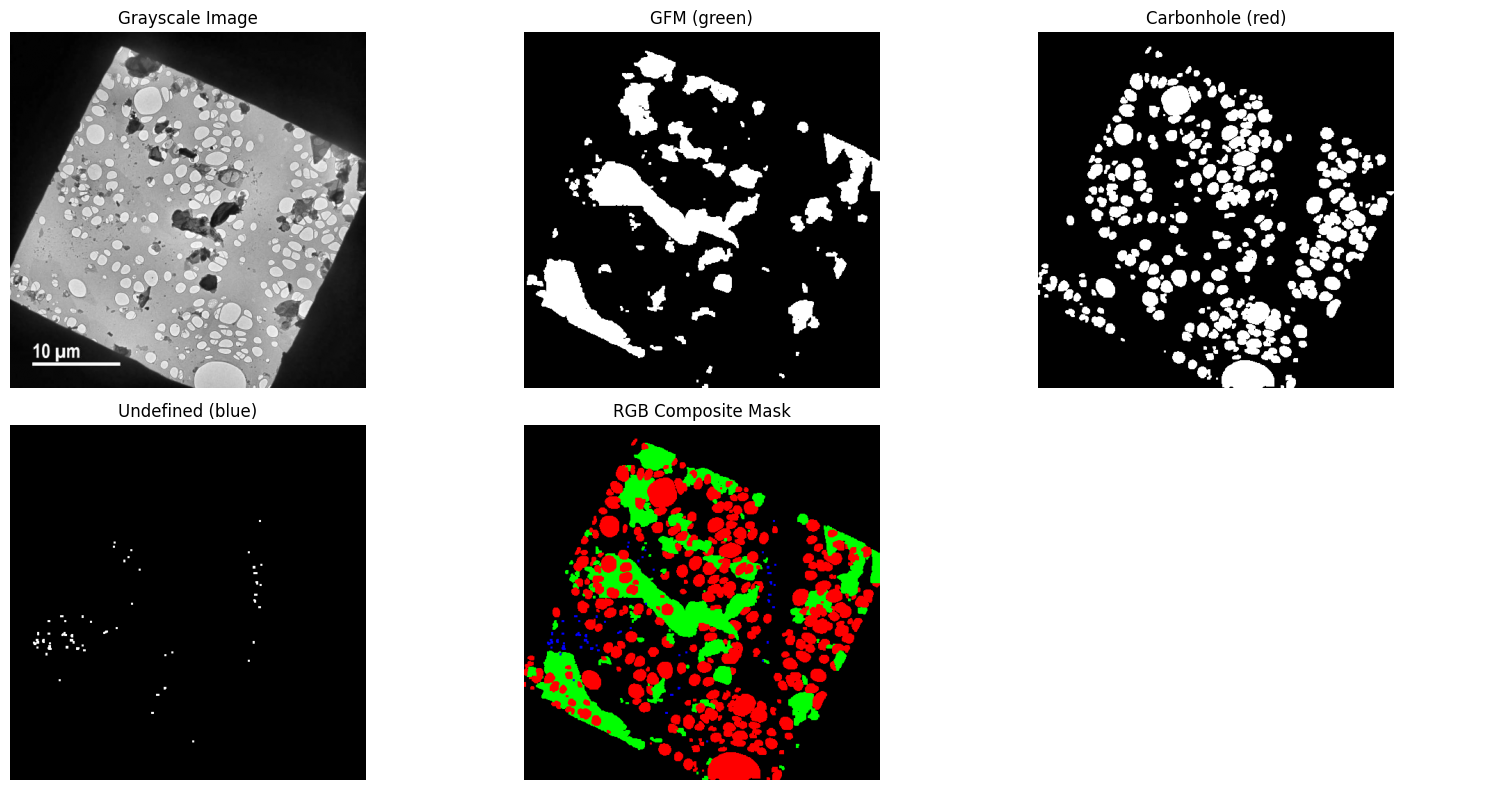

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 🎯 Display an exemplary image–mask pair
common_names = sorted(image_set & mask_set)
if not common_names:
    print("⚠️ No matching image–mask pairs to display.")
else:
    sample_name = common_names[0]
    print(f"\n🖼️ Displaying sample: {sample_name}")

    # Build GCS paths directly (no os.path.join for gs:// URIs)
    image_path = f"{IMAGE_DIR}/{sample_name}.png"
    mask_path  = f"{MASK_DIR}/{sample_name}.npz"

    # Load image (grayscale) and mask
    with fs.open(image_path, 'rb') as f:
        image = np.array(Image.open(f).convert('L'))

    with fs.open(mask_path, 'rb') as f:
        mask = np.load(f)['mask']  # expected shape (H, W, 3) or (3, H, W)

    # Ensure mask shape is (H, W, 3)
    if mask.ndim == 3 and mask.shape[0] == 3:
        mask = np.moveaxis(mask, 0, -1)

    # Create RGB composite mask for visualization
    rgb_mask = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    rgb_mask[mask[:, :, 0] == 1] = [0, 255, 0]     # GFM → green
    rgb_mask[mask[:, :, 1] == 1] = [255, 0, 0]     # carbonhole → red
    rgb_mask[mask[:, :, 2] == 1] = [0, 0, 255]     # undefined → blue

    # Plot
    fig, axs = plt.subplots(2, 3, figsize=(16, 8))

    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title("Grayscale Image")

    axs[0, 1].imshow(mask[:, :, 0], cmap='gray')
    axs[0, 1].set_title("GFM (green)")

    axs[0, 2].imshow(mask[:, :, 1], cmap='gray')
    axs[0, 2].set_title("Carbonhole (red)")

    axs[1, 0].imshow(mask[:, :, 2], cmap='gray')
    axs[1, 0].set_title("Undefined (blue)")

    axs[1, 1].imshow(rgb_mask)
    axs[1, 1].set_title("RGB Composite Mask")

    axs[1, 2].axis('off')  # unused slot

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()



## 3) Dataset class (GCS) + Sanity Visualization

**Actions**
- Defines `MultiMaskDataset`, a PyTorch `Dataset` that:
  - Reads **grayscale images** (`.png`) and **multi-label masks** (`.npz`) **directly from GCS** using `gcsfs`.
  - Resizes images with **bilinear** interpolation; resizes masks with **nearest-neighbor** (to avoid soft edges).
  - Accepts masks in shapes `(H,W,3)` or `(3,H,W)` and normalizes to tensors `[C,H,W]`.
  - **Re-binarizes** masks after resizing via `binarize_thresh` (default `0.5`) to ensure values are `{0,1}`.
  - (Optional) Performs **morphological cleaning** (opening + closing) per channel if `scipy` is available and `morph_iters>0`.
  - (Optional) **Merges “undefined”** (3rd channel) by dropping it (`merge_undefined=True` → output has 2 channels: GFM & Carbonhole).
- Instantiates the dataset with the **matched lists** from the previous step (`MATCHED_IMAGE_PATHS`, `MATCHED_MASK_PATHS`) and prints shapes/ranges.
- Plots:
  - Per-channel masks (GFM / Carbonhole / Undefined).
  - A **composite RGB overlay** (green = GFM, red = Carbonhole, blue = Undefined) on top of the grayscale image.

**Input**
- Python objects from the previous cell:
  - `fs` – initialized `gcsfs.GCSFileSystem`.
  - `MATCHED_IMAGE_PATHS` – list of GCS paths to `.png` images.
  - `MATCHED_MASK_PATHS` – list of GCS paths to `.npz` masks (with key `mask` or first array).
- Key parameters:
  - `size=(512,512)` – target spatial size.
  - `merge_undefined` (bool) – drop channel 2 if `True`.
  - `binarize_thresh` (float) – binarization threshold after resizing.
  - `morph_iters` (int) – iterations of opening+closing (requires `scipy`).

**Output**
- A PyTorch dataset `dataset` where each sample is:
  - `image`: `torch.float32` tensor `[1,H,W]`, values in `[0,1]`.
  - `mask`:  `torch.float32` tensor `[C,H,W]`, with `C=3` (or `2` if `merge_undefined=True`), values in `{0,1}`.
- Printed diagnostics (tensor shapes, dtype, min/max, unique values).
- Two figures:
  1. Per-channel mask visualization.
  2. Composite RGB overlay on the image.

**Explanation**
This cell encapsulates **data I/O and integrity** for training:
- Images and masks are read **on the fly from GCS** (no local copies needed).
- For segmentation, masks must remain **binary and perfectly aligned** with images.  
  - We therefore resize with **nearest-neighbor** for masks (no interpolation artifacts), then re-binarize.
  - Optional **morphology** (opening/closing) removes small speckles/holes caused by acquisition or preprocessing.
- The option to **merge the “undefined” class** lets you reduce the task to **two foreground channels** (GFM / Carbonhole) when that is beneficial for loss design or class balance.
- The visualizations are a quick **sanity check** that labels match the image content and that the channel mapping (GFM/Carbonhole/Undefined) is correct—analogicznie do kontroli jakości danych w eksperymencie: zanim uruchomisz analizę, sprawdzasz, że odczyty i adnotacje są spójne.


Image shape: torch.Size([1, 512, 512]), dtype: torch.float32, range: 0.01–1.00
Mask shape: torch.Size([3, 512, 512]), dtype: torch.float32, unique values (sampled): tensor([0., 1.])


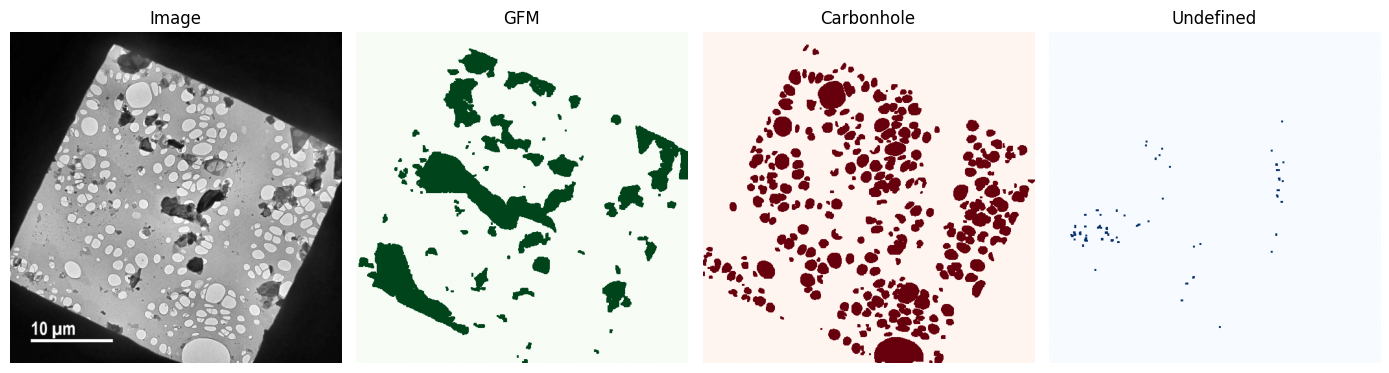

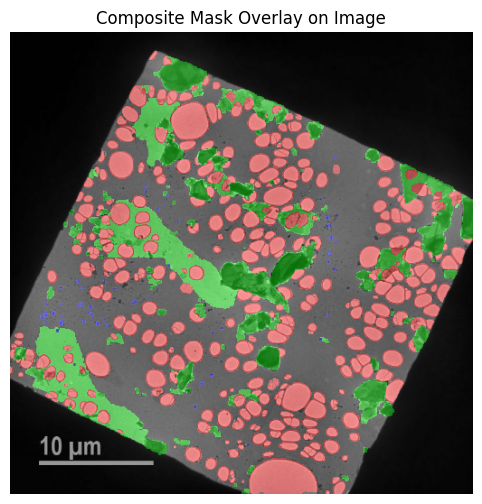

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

try:
    import scipy.ndimage as ndi
except Exception:
    ndi = None  # morphological cleaning will be disabled if scipy is unavailable


class MultiMaskDataset(Dataset):
    """
    Dataset for grayscale images and multi-label masks stored on GCS.

    Inputs:
      - fs: gcsfs filesystem object (has .open and .glob)
      - image_paths: list[str] of matched image paths (e.g., gs://.../file.png)
      - mask_paths:  list[str] of matched mask paths  (e.g., gs://.../file.npz)
      - size: (W, H) or (H, W) target size for resizing
      - merge_undefined: if True, drop the 3rd channel ("undefined") -> output has 2 channels
      - binarize_thresh: threshold applied after resizing to re-binarize masks
      - morph_iters: if > 0 and scipy available, apply opening+closing to clean masks

    Returns:
      - image: torch.float32 tensor [1, H, W], range [0, 1]
      - mask:  torch.float32 tensor [C, H, W], C=2 if merge_undefined else 3, values {0,1}
    """
    def __init__(
        self,
        fs,
        image_paths,
        mask_paths,
        size=(512, 512),
        merge_undefined=False,
        binarize_thresh=0.5,
        morph_iters=0
    ):
        assert len(image_paths) == len(mask_paths), "Image and mask lists must be 1:1 matched."
        self.fs = fs
        self.image_paths = list(image_paths)
        self.mask_paths = list(mask_paths)
        self.size = tuple(size)
        self.merge_undefined = merge_undefined
        self.binarize_thresh = float(binarize_thresh)
        self.morph_iters = int(morph_iters)

    def __len__(self):
        return len(self.image_paths)

    def _morph_clean(self, arr):
        """Apply binary opening then closing; requires scipy."""
        if self.morph_iters <= 0 or ndi is None:
            return arr
        arr_bool = arr.astype(bool)
        arr_bool = ndi.binary_opening(arr_bool, iterations=self.morph_iters)
        arr_bool = ndi.binary_closing(arr_bool, iterations=self.morph_iters)
        return arr_bool.astype(np.float32)

    def __getitem__(self, idx):
        # --- Load image (grayscale) from GCS ---
        with self.fs.open(self.image_paths[idx], 'rb') as f:
            img = Image.open(f).convert('L')
            img = img.resize(self.size, resample=Image.BILINEAR)
            img = np.array(img, dtype=np.float32) / 255.0  # [H, W] in [0,1]
            img = torch.from_numpy(img).unsqueeze(0)       # [1, H, W]

        # --- Load mask from GCS ---
        with self.fs.open(self.mask_paths[idx], 'rb') as f:
            data = np.load(f)
            # support keys: 'mask' (preferred) or first array in the npz
            if 'mask' in data:
                mask = data['mask']
            else:
                # fallback: take first array
                key0 = list(data.keys())[0]
                mask = data[key0]

        # Ensure mask shape is (H, W, 3)
        if mask.ndim == 3 and mask.shape[0] == 3:
            mask = np.moveaxis(mask, 0, -1)  # (3,H,W) -> (H,W,3)
        elif mask.ndim == 2:
            # rare case: single-channel stored; treat as foreground of channel 0
            h, w = mask.shape
            m3 = np.zeros((h, w, 3), dtype=mask.dtype)
            m3[..., 0] = mask
            mask = m3
        else:
            # expect (H, W, 3)
            pass

        # Convert to uint8 image for nearest-neighbor resizing (avoid interpolation artifacts)
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))
        mask_img = mask_img.resize(self.size, resample=Image.NEAREST)
        mask = np.array(mask_img).astype(np.float32) / 255.0  # back to float in [0,1], (H,W,3)

        # Re-binarize per channel (robust to small interpolation noise)
        mask = (mask >= self.binarize_thresh).astype(np.float32)

        # Optional morphological cleaning per channel
        if self.morph_iters > 0 and ndi is not None:
            for c in range(min(3, mask.shape[-1])):
                mask[..., c] = self._morph_clean(mask[..., c])

        # Merge undefined -> background by dropping channel 2
        if self.merge_undefined:
            # Keep only channels [0]=GFM and [1]=carbonhole
            mask = mask[..., :2]  # (H,W,2)

        # To tensor [C, H, W]
        mask_t = torch.from_numpy(mask).permute(2, 0, 1).contiguous().float()

        return img.float(), mask_t


# ===== Sanity check using the previously matched lists =====
# Assumes you already created MATCHED_IMAGE_PATHS and MATCHED_MASK_PATHS in the pairing cell
dataset = MultiMaskDataset(
    fs=fs,
    image_paths=MATCHED_IMAGE_PATHS,
    mask_paths=MATCHED_MASK_PATHS,
    size=IMG_SIZE,
    merge_undefined=False,   # set True if you want NUM_CLASSES = 2
    binarize_thresh=0.5,
    morph_iters=0            # set to 1..2 if you want light cleaning
)

sample_img, sample_mask = dataset[0]
print(f"Image shape: {sample_img.shape}, dtype: {sample_img.dtype}, "
      f"range: {float(sample_img.min()):.2f}–{float(sample_img.max()):.2f}")
print(f"Mask shape: {sample_mask.shape}, dtype: {sample_mask.dtype}, "
      f"unique values (sampled): {torch.unique(sample_mask)}")

# --- Visualization (handles 2 or 3 channels) ---
num_ch = sample_mask.shape[0]
plt.figure(figsize=(14, 6))
plt.subplot(1, num_ch + 1, 1)
plt.imshow(sample_img[0].cpu(), cmap='gray')
plt.title("Image"); plt.axis('off')

titles = ["GFM", "Carbonhole", "Undefined"]
cmaps  = ["Greens", "Reds", "Blues"]
for c in range(num_ch):
    plt.subplot(1, num_ch + 1, c + 2)
    plt.imshow(sample_mask[c].cpu(), cmap=cmaps[c])
    plt.title(titles[c]); plt.axis('off')
plt.tight_layout()
plt.show()

# --- RGB composite overlay (works for 2 or 3 channels) ---
img_np = sample_img[0].cpu().numpy()
msk_np = sample_mask.cpu().numpy()  # [C,H,W]

# Build overlay in RGB
overlay = np.zeros((msk_np.shape[1], msk_np.shape[2], 3), dtype=np.uint8)
if num_ch >= 1:
    overlay[msk_np[0] == 1] = [0, 255, 0]   # GFM -> green
if num_ch >= 2:
    overlay[msk_np[1] == 1] = [255, 0, 0]   # Carbonhole -> red
if num_ch >= 3:
    overlay[msk_np[2] == 1] = [0, 0, 255]   # Undefined -> blue

plt.figure(figsize=(12, 6))
plt.imshow(img_np, cmap='gray')
plt.imshow(overlay, alpha=0.4)
plt.title("Composite Mask Overlay on Image")
plt.axis('off')
plt.show()


## 4) Dataset utilities: pixel statistics, plots, and robust splits

**Actions**
- Provides small, reusable utilities to **inspect label balance** and to create **safe train/val/test splits**:
  - `_base_and_index(ds, i)`: resolves the original dataset and true index when `ds` is a `Subset`. Used so file names remain traceable after splitting.
  - `pixel_stats_per_image(dataset)`: for each item returns `(filename, [pixel_count_per_class])`. Helps detect empty labels, heavy class imbalance, or mislabeled files.
  - `count_pixels(dataset, num_classes=None)`: sums pixels per class over the whole (sub)dataset. Useful for computing **class weights** or quick imbalance diagnostics.
  - `plot_pixel_stats(stats, class_labels=None)`: draws a **stacked bar chart** of per-image pixel counts (one color per class). Makes sparse/empty masks instantly visible.
  - `manual_split(dataset, train_idx, val_idx, test_idx)`: creates explicit, **disjoint** splits from index lists, with range and duplication checks.
  - `_per_item_counts(dataset, num_classes=None)`: caches per-item class pixel counts to speed up repeated feasibility checks.
  - `stratified_random_split(dataset, train_size, val_size, test_size, seed, max_tries, required_channels=(0,1))`:
    - repeatedly shuffles indices until **each split contains >0 pixels** for all `required_channels` (by default: channels 0=GFM and 1=Carbonhole),
    - returns three `Subset`s or raises if no valid split is found within `max_tries`.

**Input**
- A PyTorch dataset (typically `MultiMaskDataset`) or its `Subset`s that return:
  - `image: [1,H,W]` in `[0,1]`
  - `mask:  [C,H,W]` in `{0,1}` with `C∈{2,3}`.
- (Optional) Lists of indices for `manual_split`.
- (Optional) Class names for plotting: `class_labels=["GFM","Carbonhole","Undefined"]`.

**Output**
- Diagnostics:
  - `stats = pixel_stats_per_image(...)` → list of `(filename, [c0, c1, c2])`.
  - `totals = count_pixels(...)` → tensor of total pixels per class.
  - A **stacked bar plot** from `plot_pixel_stats(stats, ...)`.
- Train/val/test subsets:
  - From `manual_split(...)` (when indices are curated),
  - Or from `stratified_random_split(...)` (when you want automatic yet **label-covering** splits).

**Explanation**
Class imbalance and accidental empty masks are common pitfalls in segmentation.  
These utilities allow you to:
- **Measure** how many pixels belong to each class per image (and globally),  
- **Visualize** the distribution with bar plots (to spot outliers or empty masks easily),  
- **Split the dataset** so that every subset contains at least some pixels of key classes (here: GFM and Carbonhole).  

This prevents situations where the model trains on a set without signal for one class, which would make the metrics misleading and the training unstable.  

In practice: first run `pixel_stats_per_image` and `plot_pixel_stats` to inspect label distribution; then use `stratified_random_split` (or `manual_split`) to build **safe and representative** train/val/test sets.



In [5]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Subset
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
from torch.utils.data import Subset


def _base_and_index(ds, i):
    """
    Resolve base dataset and real index if ds is a Subset.
    Returns (base_dataset, real_index).
    """
    if isinstance(ds, Subset):
        return ds.dataset, ds.indices[i]
    return ds, i

def pixel_stats_per_image(dataset):
    """
    Compute per-image pixel counts for each class.

    Args:
        dataset: MultiMaskDataset or Subset of it.
                 Must return (img [1,H,W], mask [C,H,W]) with mask in {0,1}.

    Returns:
        stats: list of (filename, [counts_per_class])
               e.g. [("0001.png", [123, 45, 0]), ...]
    """
    stats = []
    with torch.no_grad():
        for idx in range(len(dataset)):
            base, real_idx = _base_and_index(dataset, idx)
            _, mask = dataset[idx]  # mask: [C,H,W]
            counts = mask.sum(dim=(1, 2)).tolist()  # per-class pixel sums
            # try to get filename from base dataset
            if hasattr(base, "image_paths"):
                fname = os.path.basename(base.image_paths[real_idx])
            else:
                fname = f"idx_{real_idx}"
            stats.append((fname, counts))
    return stats

# === Pixel counting ===
def count_pixels(dataset, num_classes=None):
    """
    Sum of pixels per class in a dataset/subset.
    Assumes masks returned as [C,H,W] with values in {0,1}.
    """
    if len(dataset) == 0:
        raise ValueError("Empty dataset provided to count_pixels().")

    if num_classes is None:
        _, m0 = dataset[0]
        num_classes = m0.shape[0]

    totals = torch.zeros(num_classes, dtype=torch.float64)
    with torch.no_grad():
        for _, mask in dataset:
            if mask.shape[0] != num_classes:
                raise ValueError(f"Mask channels mismatch: expected {num_classes}, got {mask.shape[0]}")
            totals += mask.sum(dim=(1, 2)).to(dtype=torch.float64)
    return totals

import numpy as np
import matplotlib.pyplot as plt

def plot_pixel_stats(stats, class_labels=None):
    """
    Stacked bar plot of per-image pixel counts.

    Args:
        stats: list of (filename, [counts_per_class]),
               e.g. [("0001.png", [123, 45, 0]), ...]
        class_labels: optional list of class names; defaults to ["C0", "C1", ...].
    """
    if not stats:
        print("⚠️ No stats to plot.")
        return

    names = [s[0] for s in stats]
    counts = np.array([s[1] for s in stats], dtype=np.float64)  # shape: [N, C]
    N, C = counts.shape

    if class_labels is None:
        class_labels = [f"C{c}" for c in range(C)]
    if len(class_labels) != C:
        raise ValueError(f"class_labels length {len(class_labels)} does not match number of classes {C}")

    x = np.arange(N)
    bottom = np.zeros(N, dtype=np.float64)

    plt.figure(figsize=(max(8, N * 0.5), 4))
    for c in range(C):
        plt.bar(x, counts[:, c], bottom=bottom, label=class_labels[c])
        bottom += counts[:, c]

    plt.xticks(x, names, rotation=45, ha='right')
    plt.ylabel("Pixel count")
    plt.title("Pixel counts per image")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
# === Manual split ===
def manual_split(dataset, train_idx, val_idx, test_idx):
    """
    Manual dataset split based on explicit, disjoint indices.
    """
    all_idx = list(train_idx) + list(val_idx) + list(test_idx)
    if len(set(all_idx)) != len(all_idx):
        raise ValueError("train/val/test indices must be disjoint (no duplicates).")
    if not all(0 <= i < len(dataset) for i in all_idx):
        raise ValueError("Found index outside dataset range.")
    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)


# === Stratified random split ===
def _per_item_counts(dataset, num_classes=None):
    """
    Compute per-item pixel counts once (to speed up repeated checks).
    Returns np.ndarray of shape [N, C].
    """
    if len(dataset) == 0:
        raise ValueError("Empty dataset provided to _per_item_counts().")
    if num_classes is None:
        _, m0 = dataset[0]
        num_classes = m0.shape[0]

    counts = np.zeros((len(dataset), num_classes), dtype=np.float64)
    with torch.no_grad():
        for i in range(len(dataset)):
            _, mask = dataset[i]
            if mask.shape[0] != num_classes:
                raise ValueError(f"Mask channels mismatch at idx {i}: expected {num_classes}, got {mask.shape[0]}")
            counts[i] = mask.sum(dim=(1, 2)).cpu().numpy()
    return counts


def stratified_random_split(dataset,
                            train_size,
                            val_size,
                            test_size,
                            seed=None,
                            max_tries=1000,
                            required_channels=(0, 1)):
    """
    Randomly split dataset until each subset has >0 pixels for all required channels.
    Sizes are absolute counts and must sum to len(dataset).
    """
    n = len(dataset)
    if train_size + val_size + test_size != n:
        raise ValueError(f"Sizes must sum to len(dataset)={n}, got {train_size}+{val_size}+{test_size}.")

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    per_item = _per_item_counts(dataset)
    C = per_item.shape[1]

    indices = list(range(n))
    for attempt in range(1, max_tries + 1):
        random.shuffle(indices)
        train_idx = indices[:train_size]
        val_idx   = indices[train_size:train_size + val_size]
        test_idx  = indices[train_size + val_size:]

        train_counts = per_item[train_idx].sum(axis=0)
        val_counts   = per_item[val_idx].sum(axis=0)
        test_counts  = per_item[test_idx].sum(axis=0)

        ok_train = all(train_counts[rc] > 0 for rc in required_channels)
        ok_val   = all(val_counts[rc]   > 0 for rc in required_channels)
        ok_test  = all(test_counts[rc]  > 0 for rc in required_channels)

        if ok_train and ok_val and ok_test:
            print(f"✅ Stratified split found in {attempt} attempt(s).")
            return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

    raise RuntimeError("Failed to find a valid stratified split within max_tries.")


## 4. Dataset Loading, Splitting, and Augmentation  

In this step, the full dataset is loaded, analyzed, split into training, validation, and test subsets, and finally extended with **data augmentation** for the training set.  
The goal is not only to ensure that each subset is representative but also to improve model generalization by introducing controlled variability during training.  

### 🔹 Load Dataset  
- **`MultiMaskDataset`** is initialized with paths to images and masks.  
- The dataset automatically resizes all images and masks to the specified `IMG_SIZE`.  
- Once loaded, the dataset provides both the images and their corresponding multi-class masks.  

### 🔹 Pixel Counts (Before Split)  
- **`pixel_stats_per_image(full_dataset)`** reports per-image class distribution:  
  - Channel 0 → GFM  
  - Channel 1 → Carbonhole  
  - Channel 2 → Undefined  
- Results are printed in the console and visualized with a stacked bar chart (`plot_pixel_stats`).  
- This step serves as a **sanity check**, making sure that each image contains meaningful pixel counts and that class imbalance is visible.  

### 🔹 Inspect Filenames  
- A list of dataset indices and corresponding filenames is printed.  
- This helps in designing a **manual split** if specific images need to be assigned to train/val/test sets.  

### 🔹 Splitting Strategies  
Two options are provided:  

1. **Stratified Random Split (Option A)**  
   - Automatically splits the dataset into train/validation/test sets based on predefined ratios.  
   - Ensures that each subset contains at least some pixels of both GFM and Carbonhole classes.  
   - Can be activated by uncommenting the corresponding code block.  

2. **Manual Split (Option B)**  
   - Explicitly defines the indices of images for train/val/test sets.  
   - Useful when working with a small dataset or when controlling exactly which images go into which subset.  
   - Includes validation checks to prevent index out-of-range errors and data leakage between subsets.  

        #### Why Manual Split?  
        - **Small dataset size** → with only a handful of TEM images, each sample carries significant information.  
        - **Control over diversity** → ensures that different structural patterns (e.g., images with many carbon holes vs. dispersed GFM) appear in both training and validation/test sets.  
        - **Reproducibility** → explicitly storing indices makes it easy for others to replicate the exact experimental setup.  
        - **Avoiding poor random splits** → prevents situations where one class is missing from a subset, which would make training unstable or invalid.  

### 🔹 Pixel Counts (After Split)  
- For each subset (train/val/test), pixel counts are calculated and displayed.  
- A warning is issued if any subset lacks coverage of either GFM or Carbonhole, as this would compromise model training and evaluation.  

### 🔹 Data Augmentation (Training Set Only)  
To reduce overfitting and increase the model’s robustness, the **training set** is wrapped in an augmentation layer:  

- **`RandomAugmentTensor`**  
  - Applies safe, label-preserving transformations directly on tensors.  
  - Includes:  
    - Horizontal and vertical flips,  
    - 90° rotations (no interpolation artifacts),  
    - Mild brightness and contrast changes (image only, masks remain unchanged).  
  - Mask integrity is preserved using **nearest-neighbor operations** and binary re-thresholding.  

- **`AugmentedDatasetWrapper`**  
  - Wraps the original `train_set` and applies `RandomAugmentTensor` on-the-fly.  
  - Ensures that every training epoch sees slightly different variations of the same samples.  
  - Validation and test sets are **not augmented**, keeping evaluation fair and consistent.  

---

## 🔹 Patch-Based Cropping (Data Augmentation by Grid Extraction)

To improve the model’s ability to capture **small structures** (such as carbonholes),  
the training dataset is extended by splitting each **512×512 image** into multiple smaller **patches**.

### Why Cropping?
- **Preserve details** → resizing large images down to the model input size may erase fine structures.  
- **Data expansion** → each full-size image produces multiple patches, effectively increasing dataset size.  
- **Better class balance** → patches containing carbonholes are guaranteed to appear in training, even if they are rare in full images.  
- **Stability** → smaller crops reduce overfitting and force the model to generalize across different regions of the image.  

### How It Works
- Implemented via the custom `PatchGridDataset` class.  
- Each image (e.g., 512×512) is divided into a grid of **non-overlapping patches** (e.g., 4 patches of 256×256 when stride=256).  
- Optional filtering:
  - **`drop_empty=True`** → skip patches that contain no GFM or carbonhole pixels.  
  - **`min_foreground_px`** → require a minimum number of foreground pixels (GFM + Carbonhole) to keep the patch.  
- Augmentations (flips, rotations, brightness/contrast) are applied **after cropping**.  
- Only the **training set** is patched; validation and test sets remain full-size for fair evaluation.  

### Benefits
- Significantly increases the number of training samples.  
- Provides more balanced exposure to challenging regions.  
- Improves robustness of the model, especially on small or sparse features.  

---

✅ With patch cropping, each training epoch sees **more diverse and detailed samples**, while validation and test remain untouched, ensuring reliable evaluation.


✅ At this stage, the dataset is fully loaded, inspected, split into subsets, and enhanced with **on-the-fly augmentation** for the training set.  
This ensures both **representative sampling** and **improved generalization performance** in the upcoming training step.  


In [6]:
# === Patch dataset: split base dataset into a grid of patches, with useful knobs for foreground, edges and SSL ===
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F
import random

class PatchGridDataset(Dataset):
    """
    Create patches from a base dataset.
      - base_ds: dataset returning (img [1,H,W], mask [C,H,W]) tensors in [0,1] and {0,1}
      - patch_size: int; side length of square patches
      - stride: int; step between patch starts (patch_size==stride -> non-overlapping)
      - drop_empty: drop patches that do not meet FG criteria (see below)
      - min_foreground_px: minimum number of foreground pixels required to keep a patch
      - min_foreground_ratio: alternatively, require a minimum FG ratio in [0,1]
      - channels_for_fg: which mask channels count as foreground (default: (0,1) -> GFM + Carbonhole)
      - cover_full: if True, include edge patches to cover full H,W even when not divisible by patch_size
      - pad_to_fit: if True, pad img/mask so H,W become multiples of patch_size (applied on the fly in __getitem__)
      - pad_value: value to pad images with (mask is always padded with 0)
      - return_coords: if True, __getitem__ returns (img, mask, (img_idx, y, x))
    """
    def __init__(self,
                 base_ds,
                 patch_size=256,
                 stride=256,
                 transform=None,
                 drop_empty=False,
                 min_foreground_px=0,
                 min_foreground_ratio=None,
                 channels_for_fg=(0, 1),
                 cover_full=True,
                 pad_to_fit=False,
                 pad_value=0.0,
                 return_coords=False):
        self.base = base_ds
        self.ps = int(patch_size)
        self.stride = int(stride)
        self.transform = transform
        self.drop_empty = bool(drop_empty)
        self.min_fg_px = int(min_foreground_px)
        self.min_fg_ratio = None if min_foreground_ratio is None else float(min_foreground_ratio)
        self.channels_for_fg = tuple(channels_for_fg) if channels_for_fg is not None else ()
        self.cover_full = bool(cover_full)
        self.pad_to_fit = bool(pad_to_fit)
        self.pad_value = float(pad_value)
        self.return_coords = bool(return_coords)

        # Build patch index AFTER dataset split to avoid mixing folds
        self.index = []  # list of (img_idx, y, x)
        for i in range(len(base_ds)):
            _, m = base_ds[i]               # [C,H,W]
            C, H, W = m.shape
            assert C >= 1, "Mask must have at least 1 channel."
            # compute grid starts
            ys = list(range(0, max(H - self.ps + 1, 1), self.stride))
            xs = list(range(0, max(W - self.ps + 1, 1), self.stride))
            if self.cover_full:
                if ys[-1] != max(H - self.ps, 0):
                    ys.append(max(H - self.ps, 0))
                if xs[-1] != max(W - self.ps, 0):
                    xs.append(max(W - self.ps, 0))

            # select FG channels safely
            fg_ch = [ch for ch in self.channels_for_fg if 0 <= ch < C]
            for y in ys:
                for x in xs:
                    keep = True
                    if self.drop_empty or self.min_fg_px > 0 or (self.min_fg_ratio is not None):
                        if fg_ch:
                            sub = m[fg_ch, y:y+self.ps, x:x+self.ps]   # [|fg|, ps, ps] (may be smaller near edges)
                            # If sub patch smaller (edges), we'll decide based on its actual size
                            fg_count = int(sub.sum().item())
                            if self.min_fg_px > 0 and fg_count <= self.min_fg_px:
                                keep = False
                            if keep and self.min_fg_ratio is not None:
                                area = sub.shape[1] * sub.shape[2]
                                ratio = fg_count / max(area, 1)
                                if ratio < self.min_fg_ratio:
                                    keep = False
                        else:
                            # no fg channels specified -> nothing to filter on
                            pass
                    if keep:
                        self.index.append((i, y, x))

        if len(self.index) == 0:
            raise RuntimeError("PatchGridDataset: no patches generated — check patch_size/stride/filters.")

    def __len__(self):
        return len(self.index)

    def _maybe_pad(self, img, mask):
        """Pad image/mask so that H and W are multiples of patch_size (for neat tiling)."""
        if not self.pad_to_fit:
            return img, mask
        _, H, W = img.shape
        pad_h = (self.ps - (H % self.ps)) % self.ps
        pad_w = (self.ps - (W % self.ps)) % self.ps
        if pad_h == 0 and pad_w == 0:
            return img, mask
        # Pad as (left, right, top, bottom)
        pad = (0, pad_w, 0, pad_h)
        img = F.pad(img, pad, mode='constant', value=self.pad_value)
        mask = F.pad(mask, pad, mode='constant', value=0.0)
        return img, mask

    def __getitem__(self, idx):
        i, y, x = self.index[idx]
        img, mask = self.base[i]                 # [1,H,W], [C,H,W]
        img, mask = self._maybe_pad(img, mask)
        patch_img  = img[:,  y:y+self.ps, x:x+self.ps]
        patch_mask = mask[:, y:y+self.ps, x:x+self.ps]
        if self.transform is not None:
            patch_img, patch_mask = self.transform(patch_img, patch_mask)
        if self.return_coords:
            return patch_img, patch_mask, (i, y, x)
        return patch_img, patch_mask


# === Lightweight tensor augmentations for segmentation (safe for masks) ===
import torch
import random

class RandomAugmentTensor:
    """
    Tensor-only augmentations (paired image+mask).
      img:  [1, H, W] in [0,1]
      mask: [C, H, W] in {0,1}
    Augments: random hflip, vflip, 0/90/180/270 rot, mild brightness/contrast on image ONLY.
    """
    def __init__(self,
                 p_hflip=0.5,
                 p_vflip=0.5,
                 p_rot90=0.5,
                 p_bc=0.5,
                 brightness=(0.9, 1.1),
                 contrast=(0.9, 1.1)):
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_rot90 = p_rot90
        self.p_bc    = p_bc
        self.brightness = brightness
        self.contrast   = contrast

    @torch.no_grad()
    def __call__(self, img: torch.Tensor, mask: torch.Tensor):
        # flips
        if random.random() < self.p_hflip:
            img  = torch.flip(img,  dims=[2])   # width
            mask = torch.flip(mask, dims=[2])
        if random.random() < self.p_vflip:
            img  = torch.flip(img,  dims=[1])   # height
            mask = torch.flip(mask, dims=[1])

        # rot90 (k in {0,1,2,3})
        if random.random() < self.p_rot90:
            k = random.randint(0, 3)
            if k:
                img  = torch.rot90(img,  k, dims=(1,2))
                mask = torch.rot90(mask, k, dims=(1,2))

        # brightness / contrast (image only)
        if random.random() < self.p_bc:
            b = random.uniform(*self.brightness)
            c = random.uniform(*self.contrast)
            mean = img.mean()
            img = torch.clamp((img - mean) * c + mean, 0.0, 1.0)
            img = torch.clamp(img * b, 0.0, 1.0)

        # keep masks strictly binary (just in case)
        if mask.dtype.is_floating_point:
            mask = (mask > 0.5).to(mask.dtype)

        return img, mask


class AugmentedDatasetWrapper(Dataset):
    """Wrap any dataset that returns (img_tensor, mask_tensor) to apply paired transforms."""
    def __init__(self, base_ds: Dataset, transform=None):
        self.base = base_ds
        self.transform = transform

    def __len__(self): 
        return len(self.base)

    def __getitem__(self, idx):
        img, mask = self.base[idx]  # expects tensors [1,H,W], [C,H,W]
        if self.transform is not None:
            img, mask = self.transform(img, mask)
        return img, mask


augment = RandomAugmentTensor(
    p_hflip=0.5, p_vflip=0.5, p_rot90=0.5, p_bc=0.5,
    brightness=(0.9, 1.1), contrast=(0.9, 1.1)
)

# === Hooks for ResNet / SimCLR pretraining on patches ===
class To3Channels:
    """
    Convert [1,H,W] grayscale tensor to [3,H,W] by channel replication.
    Useful for ImageNet-pretrained ResNet backbones or SSL pretraining.
    """
    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        if img.ndim == 3 and img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

class ContrastiveView:
    """
    Create one augmented view (image-only) suitable for SimCLR-style pretraining.
    NOTE: Keeps masks out; apply to image tensors only.
    """
    def __init__(self,
                 p_hflip=0.5,
                 p_vflip=0.5,
                 p_rot90=0.5,
                 p_bc=0.8,
                 brightness=(0.8, 1.2),
                 contrast=(0.8, 1.2),
                 gaussian_blur=True,
                 blur_kernel=5,
                 blur_sigma=(0.1, 1.5)):
        self.img_aug = RandomAugmentTensor(p_hflip, p_vflip, p_rot90, p_bc, brightness, contrast)
        self.to3 = To3Channels()
        self.gaussian_blur = gaussian_blur
        self.blur_kernel = blur_kernel
        self.blur_sigma = blur_sigma

    @torch.no_grad()
    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        # use the same ops as RandomAugmentTensor but ignore mask
        aug_img, _ = self.img_aug(img.clone(), (img>1).float())  # dummy mask
        aug_img = self.to3(aug_img)
        if self.gaussian_blur:
            # simple separable blur using avg_pool as a cheap approximation
            k = self.blur_kernel
            if k > 1:
                pad = k // 2
                aug_img = F.avg_pool2d(F.pad(aug_img.unsqueeze(0), (pad,pad,pad,pad), mode='reflect'),
                                       kernel_size=k, stride=1).squeeze(0)
        return aug_img

class SimCLRPatchDataset(Dataset):
    """
    Returns two independently augmented views of the SAME patch (for SSL pretraining).
      - base_patches: a PatchGridDataset (or any dataset returning (img, mask))
      - view_transform: a callable that maps [1,H,W] -> [3,H,W] with augmentations
    Output: (view1, view2)
    """
    def __init__(self, base_patches: Dataset, view_transform=None):
        self.base = base_patches
        self.view_t = view_transform or ContrastiveView()

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]  # ignore mask for SSL
        v1 = self.view_t(img)
        v2 = self.view_t(img)
        return v1, v2


## 5) Build dataset, inspect balance, split safely, and create DataLoaders

**Actions**
- Instantiates the full `MultiMaskDataset` from the previously matched GCS paths.
- Computes **per-image pixel counts** (class-wise) *before* any split and prints a readable table.
- Draws a **stacked bar chart** to visualize class balance across images.
- Shows an **index → filename** map to help curate a manual split if desired.
- Creates **train/val/test** splits in one of two ways:
  - **Manual** (current default): uses explicitly listed indices with duplication/range checks.
  - **Stratified random** (toggle by setting `USE_MANUAL_SPLIT=False`): repeatedly shuffles until each split contains **>0 pixels** of the required channels (GFM & Carbonhole).
- Verifies each split’s class coverage (warns if a split lacks pixels of GFM or Carbonhole).
- Prepares **patch-based training** via `PatchGridDataset`:
  - Makes non-overlapping `256×256` patches from `512×512` images,
  - Keeps only patches with at least `min_foreground_px=10` pixels in channels (0,1),
  - Applies **paired augmentations** to patches (train only).
- Builds **PyTorch DataLoaders**:
  - `train_loader` reading augmented **patches** (shuffled, `drop_last=True`),
  - `val_loader` and `test_loader` reading **full images** (no augmentation, no patching).
- Provides a **safe default augmentation** (`RandomAugmentTensor`) if none was defined earlier.

**Input**
- From earlier cells:
  - `fs`, `MATCHED_IMAGE_PATHS`, `MATCHED_MASK_PATHS`, `IMG_SIZE`,
  - Utility functions: `pixel_stats_per_image`, `plot_pixel_stats`, `count_pixels`, `manual_split`, `stratified_random_split`,
  - (Optionally) `augment` transform; if missing, a default is created.
- User-controlled flags/params:
  - `MERGE_UNDEFINED` (whether to drop the “Undefined” channel → `C=2`),
  - `USE_MANUAL_SPLIT` (manual vs. stratified),
  - `VAL_SPLIT`, `TEST_SPLIT` (if using stratified),
  - Patch grid parameters: `patch_size=256`, `stride=256`, `min_foreground_px=10`, `channels_for_fg=(0,1)`.

**Output**
- `full_dataset`: the complete `MultiMaskDataset`.
- Printed diagnostics:
  - Per-image pixel counts for classes (GFM, Carbonhole, [Undefined]),
  - Stacked bar plot showing class distribution per image,
  - Index → filename listing,
  - Split-wise totals via `count_pixels(...)`.
- Three dataset subsets: `train_set`, `val_set`, `test_set`.
- Patch dataset: `train_ds_grid` (derived from `train_set`).
- DataLoaders ready for training/evaluation:
  - `train_loader`, `val_loader`, `test_loader`.
- Console summary including number of train patches and counts of val/test images.

**Explanation**
This cell converts a **raw list of matched image–mask pairs** into a **training-ready pipeline**:
- We first **measure label amounts per image** to catch pitfalls (e.g., empty masks, severe imbalance) and to choose a sensible split.
- The **split step** is deliberate: either hand-picked indices (reproducible experiments, easy to track) or **stratified random** that guarantees **signal presence** (at least some GFM & Carbonhole) in every subset. This avoids degenerate validation/test sets.
- Training on **patches** focuses learning on informative regions and multiplies training samples from small datasets, while keeping **validation/test on full images** reflects the final use case and stabilizes metrics.
- Augmentations are **paired** (image & mask get identical geometric transforms) to preserve alignment; photometric changes apply only to the image.
- The end result is a **clean, balanced, and efficient** data input stage that supports robust training and fair evaluation—akin to setting up a controlled measurement protocol before running an experiment.


Loaded full dataset with 10 images (merge_undefined=False)

📊 Pixel counts per image [GFM, Carbonhole, Undefined]:
1AC_UT_GO_02_01_2000X_0002: GFM=37991, Carbonhole=50972, Undefined=688
2AC_UT_GO_02_01_2000X_0003: GFM=57919, Carbonhole=46517, Undefined=348
3AC_UT_GO_02_01_2000X_0004: GFM=78520, Carbonhole=39845, Undefined=174
4AC_UT_GO_02_01_2000X_0005: GFM=69506, Carbonhole=40754, Undefined=297
AC_UT_G_03_01_UO_200X_0002: GFM=3127, Carbonhole=55524, Undefined=90
AC_UT_G_03_01_UO_200X_0008: GFM=79173, Carbonhole=37332, Undefined=22
AC_UT_G_04_01_UO_200X_0001: GFM=50433, Carbonhole=77217, Undefined=263
AC_UT_G_04_01_UO_200X_0003: GFM=19114, Carbonhole=84525, Undefined=57
AC_UT_G_04_01_UO_200X_0006: GFM=37676, Carbonhole=60245, Undefined=0
AC_UT_G_04_01_UO_200X_0010: GFM=165382, Carbonhole=36714, Undefined=0


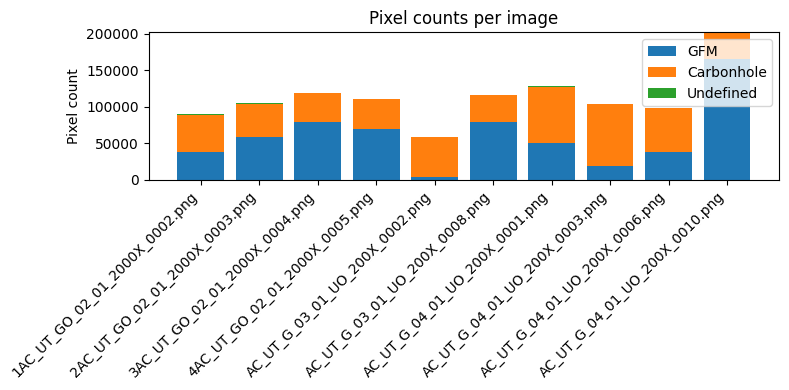


🗂️ Index → filename
 0: 1AC_UT_GO_02_01_2000X_0002.png
 1: 2AC_UT_GO_02_01_2000X_0003.png
 2: 3AC_UT_GO_02_01_2000X_0004.png
 3: 4AC_UT_GO_02_01_2000X_0005.png
 4: AC_UT_G_03_01_UO_200X_0002.png
 5: AC_UT_G_03_01_UO_200X_0008.png
 6: AC_UT_G_04_01_UO_200X_0001.png
 7: AC_UT_G_04_01_UO_200X_0003.png
 8: AC_UT_G_04_01_UO_200X_0006.png
 9: AC_UT_G_04_01_UO_200X_0010.png

📊 Pixel counts per subset:
Train: [356426.0, 361889.0, 1534.0]
Val:   [184496.0, 121239.0, 57.0]
Test:  [57919.0, 46517.0, 348.0]

✅ Dataloaders ready: train=7, val=2, test=1
   Using augmentation for TRAIN only (flips/rot90/brightness/contrast).
Train patches: 28 (from 7 images)
Val images:   2
Test images:  1


In [7]:
from torch.utils.data import DataLoader
import os
import torch

# === Build the full dataset (uses the paired lists from the pairing cell) ===
# Choose whether to merge "undefined" -> background. If True => C=2, else C=3.
MERGE_UNDEFINED = False  # set True if you want NUM_CLASSES=2

full_dataset = MultiMaskDataset(
    fs=fs,
    image_paths=MATCHED_IMAGE_PATHS,   # from the pairing cell
    mask_paths=MATCHED_MASK_PATHS,     # from the pairing cell
    size=IMG_SIZE,
    merge_undefined=MERGE_UNDEFINED,
    binarize_thresh=0.5,
    morph_iters=0
)
print(f"Loaded full dataset with {len(full_dataset)} images (merge_undefined={MERGE_UNDEFINED})")

# === Pixel counts per image BEFORE split (works for C=2 or C=3) ===
stats = pixel_stats_per_image(full_dataset)  # -> [(filename, [c0,c1,(c2)])]
num_classes_detected = len(stats[0][1]) if stats else (2 if MERGE_UNDEFINED else 3)
labels = ["GFM", "Carbonhole"] + (["Undefined"] if num_classes_detected == 3 else [])

print("\n📊 Pixel counts per image [{}]:".format(", ".join(labels)))
for name, counts in stats:
    stem = os.path.splitext(os.path.basename(name))[0] if "." in name else os.path.splitext(name)[0]
    # print dynamically
    if num_classes_detected == 3:
        print(f"{stem}: GFM={int(counts[0])}, Carbonhole={int(counts[1])}, Undefined={int(counts[2])}")
    else:
        print(f"{stem}: GFM={int(counts[0])}, Carbonhole={int(counts[1])}")

# === Plot for visual insight (auto-handles any number of classes) ===
plot_pixel_stats(stats, class_labels=labels)

# === If you want to see indices and filenames (to pick manual split) ===
print("\n🗂️ Index → filename")
for i, path in enumerate(getattr(full_dataset, "image_paths", [])):
    print(f"{i:2d}: {os.path.basename(path)}")

# === Perform split ===
USE_MANUAL_SPLIT = True  # flip to False to use stratified random split

if not USE_MANUAL_SPLIT:
    # Option A: stratified random split
    total_size = len(full_dataset)
    val_size   = max(1, int(round(total_size * VAL_SPLIT)))
    test_size  = max(1, int(round(total_size * TEST_SPLIT)))
    train_size = total_size - val_size - test_size
    if train_size <= 0:
        raise ValueError("Train size became non-positive. Adjust VAL_SPLIT/TEST_SPLIT.")

    # Require channels 0 and 1 to be present in every split (GFM, Carbonhole)
    required = (0, 1)
    train_set, val_set, test_set = stratified_random_split(
        full_dataset, train_size, val_size, test_size, seed=42, required_channels=required
    )
else:
    # Option B: manual split (edit these indices as needed)
    train_idx = [0, 2, 3, 4, 5, 6, 8]
    val_idx   = [7, 9]
    test_idx  = [1]

    # Leakage / bounds checks
    all_idx = list(train_idx) + list(val_idx) + list(test_idx)
    assert len(all_idx) == len(set(all_idx)), "❌ Some indices are duplicated across splits."
    assert max(all_idx) < len(full_dataset) and min(all_idx) >= 0, "❌ Index outside dataset range."

    # Build subsets
    train_set, val_set, test_set = manual_split(full_dataset, train_idx, val_idx, test_idx)

# === Check dataset counts ===
print("\n📊 Pixel counts per subset:")
train_counts = count_pixels(train_set, num_classes=num_classes_detected); print("Train:", train_counts.tolist())
val_counts   = count_pixels(val_set,   num_classes=num_classes_detected); print("Val:  ", val_counts.tolist())
test_counts  = count_pixels(test_set,  num_classes=num_classes_detected); print("Test: ", test_counts.tolist())

# Minimal class coverage per dataset control (require at least some GFM & Carbonhole)
for name, cnt in [("Train", train_counts), ("Val", val_counts), ("Test", test_counts)]:
    has_gfm = (cnt[0] > 0)
    has_ch  = (cnt[1] > 0)
    if not (has_gfm and has_ch):
        print(f"⚠️  Attention! In subset '{name}' there are no pixels of at least one class (GFM/Carbonhole). Consider adjusting the split.")

# === Augmented TRAIN dataset & DataLoaders ===
# If 'augment' wasn't defined (previous cell), create a safe default:
if 'augment' not in globals():
    print("ℹ️ 'augment' not found in globals – using default RandomAugmentTensor.")
    augment = RandomAugmentTensor(
        p_hflip=0.5, p_vflip=0.5, p_rot90=0.5, p_bc=0.5,
        brightness=(0.9, 1.1), contrast=(0.9, 1.1)
    )

# Patch-based training dataset: filter by FG on channels 0&1 (GFM+CH)
train_ds_grid = PatchGridDataset(
    train_set,
    patch_size=256,          # each 512x512 image → up to 4 patches
    stride=256,
    transform=augment,       # paired tensor augmentations
    drop_empty=True,
    min_foreground_px=10,
    channels_for_fg=(0, 1),  # make explicit
    cover_full=True,
    pad_to_fit=False
)

# DataLoaders (val/test keep full images, no aug, no patching)
pin_memory = bool(torch.cuda.is_available())
train_loader = DataLoader(
    train_ds_grid,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,           # bump to 2–8 if the environment allows
    pin_memory=pin_memory,
    drop_last=True
)
val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory
)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory
)

print(f"\n✅ Dataloaders ready: train={len(train_set)}, val={len(val_set)}, test={len(test_set)}")
print("   Using augmentation for TRAIN only (flips/rot90/brightness/contrast).")
print(f"Train patches: {len(train_ds_grid)} (from {len(train_set)} images)")
print(f"Val images:   {len(val_set)}")
print(f"Test images:  {len(test_set)}")


## 6) Sanity check: class balance in splits

**Actions**
- Iterates over the three dataset splits (`Train`, `Val`, `Test`).
- Uses `count_pixels` to compute total **class pixel counts** per subset.
- Collects totals for **GFM** (green) and **Carbonhole** (red).
- Issues a **warning** if any split contains **zero pixels** of either class.
- Plots a **stacked bar chart** showing GFM + Carbonhole pixel counts per subset.
- Annotates each bar with absolute counts (formatted with thousands separators).

**Input**
- `train_set`, `val_set`, `test_set` from the split cell.
- Utility function: `count_pixels`.

**Output**
- Console warnings if any split lacks GFM/Carbonhole pixels.
- A stacked bar plot with class distribution across subsets:
  - Green bars = GFM,
  - Red bars = Carbonhole,
  - Numbers inside bars = exact pixel counts.

**Explanation**
Before training a segmentation network, it is critical to **validate dataset composition**:
- Each subset (train/val/test) must contain pixels from **all key classes**; otherwise, the model might never learn to recognize missing categories.
- The stacked bar plot provides a **quick diagnostic** of relative class balance: if one class is overwhelmingly dominant, you can expect biased predictions unless countermeasures (augmentation, loss weighting) are applied.
- Think of this step as a **control experiment** in physics: verifying that your apparatus actually contains the signals you want to measure, before running the main experiment.



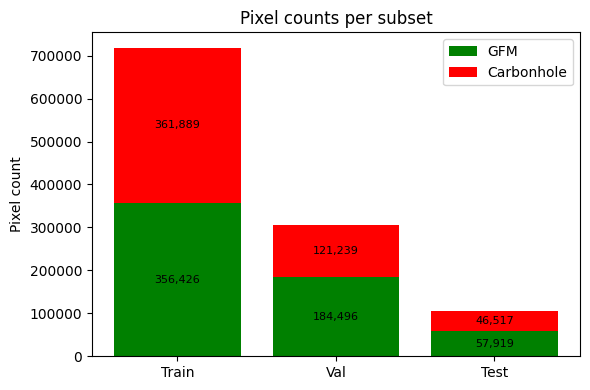

<Figure size 640x480 with 0 Axes>

In [8]:
# SANITY-CHECK
# === Barplot: pixel counts per subset ===
import numpy as np

subsets = {"Train": train_set, "Val": val_set, "Test": test_set}
subset_names = list(subsets.keys())
gfms, holes = [], []

for name, subset in subsets.items():
    counts = count_pixels(subset).cpu().numpy()  # -> [GFM, Carbonhole, Undefined]
    gfms.append(counts[0])
    holes.append(counts[1])
    # szybka kontrola pokrycia klas
    if counts[0] == 0 or counts[1] == 0:
        print(f"⚠️  Uwaga: w zbiorze {name} brakuje pikseli GFM lub Carbonhole.")

x = np.arange(len(subset_names))

plt.figure(figsize=(6,4))
plt.bar(x, gfms, label='GFM', color='green')
plt.bar(x, holes, bottom=gfms, label='Carbonhole', color='red')
plt.xticks(x, subset_names)
plt.ylabel("Pixel count")
plt.title("Pixel counts per subset")
plt.legend()
# etykiety wartości na słupkach
for i, (g, h) in enumerate(zip(gfms, holes)):
    plt.text(i, g/2, f"{int(g):,}", ha='center', va='center', fontsize=8)
    plt.text(i, g + h/2, f"{int(h):,}", ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

## 7) Strong data pipeline: augmentations, overlapping patches, loaders, cosine warmup, and TTA

**Actions**
- **Augmentations (tensor-safe)**  
  - `RandomAugmentLite`: geometric (H/V flips, 90° rotations) + photometric (brightness/contrast, Gaussian noise on image only) with binary mask preservation.  
  - `RandomScaleJitter`: random zoom in/out + center crop/pad back to `IMG_SIZE` (helps with magnification shift between 200× and 2000×).  
  - `RandomGaussianBlur`: light blur to mimic TEM softness.
  - `AugmentedDataset`: thin wrapper that applies a `(img, mask) -> (img, mask)` transform.

- **Patch extraction (training focus)**
  - Uses `PatchGridDataset` (with a safe fallback here): cuts each image into **overlapping** patches (`PATCH_SIZE=256`, `PATCH_STRIDE=128` ⇒ 50% overlap).
  - Filters out empty patches (`min_foreground_px=10` on channels 0–1) to emphasize informative regions.

- **Datasets & DataLoaders**
  - `train_ds`: either overlapping patches with augmentation or full-image dataset with augmentation (toggle `USE_PATCH_GRID`).
  - `val_ds`, `test_ds`: keep full images, **no augmentation**.
  - DataLoaders: `num_workers=0` (because `gcsfs` is not fork-safe), `pin_memory=PIN`, `drop_last=True` for train.

- **Cosine LR scheduler with warmup (per-batch)**
  - `build_cosine_warmup_scheduler(…)` returns a scheduler and `warmup_steps`.
  - Usage in training loop: linearly warm up LR for `warmup_steps`, then call `scheduler.step()` **per batch**.

- **Test-Time Augmentation (TTA)**
  - `predict_with_tta_logits(imgs)`: averages logits over identity, H-flip, V-flip, and 90° rotation (with inverse mapping).  
  - Honors an optional `normalizer` module if present.

**Input**
- Globals from earlier cells:
  - Splits: `train_set`, `val_set`, `test_set`; sizes: `IMG_SIZE`, `BATCH_SIZE`; device flags via `torch.cuda.is_available()`.
  - (Optional) pre-defined `PatchGridDataset`. If absent, a minimal fallback is defined here.
  - (Optional) `optimizer`: if present, a cosine scheduler is built immediately; otherwise the helper is left for later.

**Output**
- Transform functions: `train_transform`.
- Datasets: `train_ds` (patch or full), `val_ds`, `test_ds`.
- DataLoaders: `train_loader`, `val_loader`, `test_loader` (+ console shapes).
- LR scheduling helper: `build_cosine_warmup_scheduler` (and `scheduler`, `WARMUP_STEPS` if `optimizer` exists).
- Inference helper: `predict_with_tta_logits(imgs)` that returns averaged **logits** `[B,C,H,W]`.

**Explanation**
- **Why overlapping patches?**  
  They increase sample count, improve boundary learning, and reduce label sparsity within a patch. Overlap mitigates edge artifacts (each pixel is seen in multiple contexts).
- **Why these augmentations?**  
  Geometric transforms preserve pixel-wise alignment between image and mask; photometric noise/contrast changes reflect real TEM variability. Scale jitter explicitly addresses **magnification/domain shift** (e.g., 200× vs 2000×).
- **Why per-batch cosine + warmup?**  
  Warmup stabilizes early updates; cosine decay then anneals LR smoothly across all training steps, typically improving convergence over step-wise schedules.
- **Why TTA?**  
  Averaging predictions over symmetry transforms yields a low-cost boost in robustness (especially for anisotropic textures) without retraining.

> Practical tip: keep validation/test **without** augmentation or patching to reflect real-world inference; apply TTA only during evaluation or final inference by swapping `logits = model(imgs)` for `logits = predict_with_tta_logits(imgs)`.


In [9]:
import torch, random
from torch.utils.data import DataLoader, Dataset

PIN = torch.cuda.is_available()

# =========================
# Augmentations (tensor-safe)
# =========================
class RandomAugmentLite:
    """
    Flips, 90-deg rotations, brightness/contrast and Gaussian noise (image-only).
    Works on tensors: img [1,H,W] in [0,1], mask [C,H,W] in {0,1}.
    """
    def __init__(self, p_flip=0.5, p_rot=0.5, p_bc=0.5, max_brightness=0.08, max_contrast=0.10,
                 p_noise=0.5, noise_sigma=0.03):
        self.p_flip = p_flip; self.p_rot = p_rot; self.p_bc = p_bc
        self.max_brightness = max_brightness; self.max_contrast = max_contrast
        self.p_noise = p_noise; self.noise_sigma = noise_sigma

    @torch.no_grad()
    def __call__(self, img, mask):
        # H/V flips
        if random.random() < self.p_flip:
            img  = torch.flip(img,  dims=[2]); mask = torch.flip(mask, dims=[2])
        if random.random() < self.p_flip:
            img  = torch.flip(img,  dims=[1]); mask = torch.flip(mask, dims=[1])
        # rot90
        if random.random() < self.p_rot:
            k = random.randint(0, 3)
            if k:
                img  = torch.rot90(img,  k, dims=(1,2))
                mask = torch.rot90(mask, k, dims=(1,2))
        # brightness/contrast (image only)
        if random.random() < self.p_bc:
            c = 1.0 + random.uniform(-self.max_contrast, self.max_contrast)
            b = random.uniform(-self.max_brightness, self.max_brightness)
            img = (img * c + b).clamp(0.0, 1.0)
        # Gaussian noise (image only)
        if random.random() < self.p_noise:
            img = (img + self.noise_sigma * torch.randn_like(img)).clamp(0.0, 1.0)
        # keep masks strictly binary
        if mask.dtype.is_floating_point:
            mask = (mask > 0.5).to(mask.dtype)
        return img, mask

class RandomScaleJitter:
    """
    Random zoom in/out + center crop/pad back to IMG_SIZE.
    Helps with magnification shift (e.g., 200X vs 2000X).
    """
    def __init__(self, scale_range=(0.7, 1.6), out_size=None):
        self.smin, self.smax = scale_range
        assert out_size is not None, "Provide out_size=(H,W)"
        self.out_h, self.out_w = int(out_size[0]), int(out_size[1])

    @torch.no_grad()
    def __call__(self, img, mask):
        s = random.uniform(self.smin, self.smax)
        _, H, W = img.shape
        nh, nw = max(1, int(H*s)), max(1, int(W*s))
        img_r  = torch.nn.functional.interpolate(img.unsqueeze(0), (nh, nw), mode='bilinear', align_corners=False).squeeze(0)
        mask_r = torch.nn.functional.interpolate(mask.unsqueeze(0), (nh, nw), mode='nearest').squeeze(0)
        # pad to at least out size
        pad_h = max(0, self.out_h - nh); pad_w = max(0, self.out_w - nw)
        if pad_h or pad_w:
            img_r  = torch.nn.functional.pad(img_r,  (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            mask_r = torch.nn.functional.pad(mask_r, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        # center crop
        img_r  = img_r[:,  :self.out_h, :self.out_w]
        mask_r = mask_r[:, :self.out_h, :self.out_w]
        return img_r, mask_r

class RandomGaussianBlur:
    """Light blur to simulate TEM softness."""
    def __init__(self, p=0.3, k=3):
        self.p, self.k = p, k

    @torch.no_grad()
    def __call__(self, img, mask):
        if random.random() < self.p:
            img = torch.nn.functional.avg_pool2d(img, self.k, stride=1, padding=self.k//2)
        return img, mask

class AugmentedDataset(Dataset):
    """Wrap any dataset returning (img, mask) tensors."""
    def __init__(self, base, transform=None):
        self.base = base; self.transform = transform
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, mask = self.base[idx]
        if self.transform is not None:
            img, mask = self.transform(img, mask)
        return img, mask

# =========================
# Patch grid (overlap)
# =========================
# Uses your earlier PatchGridDataset if defined; else define a minimal fallback:
if 'PatchGridDataset' not in globals():
    class PatchGridDataset(Dataset):
        def __init__(self, base_ds, patch_size=256, stride=256, transform=None, drop_empty=False, min_foreground_px=0):
            self.base = base_ds; self.ps=int(patch_size); self.stride=int(stride)
            self.transform = transform; self.drop_empty=bool(drop_empty); self.min_fg=int(min_foreground_px)
            self.index=[]
            for i in range(len(base_ds)):
                _, m = base_ds[i]  # [C,H,W]
                C,H,W = m.shape
                for y in range(0, H - self.ps + 1, self.stride):
                    for x in range(0, W - self.ps + 1, self.stride):
                        if self.drop_empty or self.min_fg>0:
                            sub = m[:2, y:y+self.ps, x:x+self.ps]
                            if int(sub.sum().item()) <= self.min_fg: continue
                        self.index.append((i,y,x))
            if not self.index:
                raise RuntimeError("PatchGridDataset produced 0 patches — check sizes/stride.")
        def __len__(self): return len(self.index)
        def __getitem__(self, idx):
            i,y,x = self.index[idx]
            img, mask = self.base[i]
            img  = img[:,  y:y+self.ps, x:x+self.ps]
            mask = mask[:, y:y+self.ps, x:x+self.ps]
            if self.transform is not None:
                img, mask = self.transform(img, mask)
            return img, mask

# =========================
# Compose the TRAIN transform
# =========================
# Needs global IMG_SIZE, e.g., (512,512)
assert 'IMG_SIZE' in globals(), "IMG_SIZE is required."
_scale = RandomScaleJitter(scale_range=(0.7, 1.6), out_size=IMG_SIZE)
_base  = RandomAugmentLite(p_flip=0.5, p_rot=0.5, p_bc=0.5, max_brightness=0.08, max_contrast=0.10,
                           p_noise=0.5, noise_sigma=0.03)
_blur  = RandomGaussianBlur(p=0.30, k=3)

def train_transform(img, mask):
    img, mask = _scale(img, mask)
    img, mask = _base(img, mask)
    img, mask = _blur(img, mask)
    return img, mask

# =========================
# Build datasets & loaders
# =========================
assert 'train_set' in globals() and 'val_set' in globals() and 'test_set' in globals(), "Define splits first."

USE_PATCH_GRID = True          # <- turn ON to train on overlapping patches
PATCH_SIZE     = 256
PATCH_STRIDE   = 128           # overlap 50%

if USE_PATCH_GRID:
    train_ds = PatchGridDataset(
        train_set,
        patch_size=PATCH_SIZE,
        stride=PATCH_STRIDE,
        transform=train_transform,
        drop_empty=True,
        min_foreground_px=10
    )
else:
    train_ds = AugmentedDataset(train_set, transform=train_transform)

val_ds  = val_set   # no augmentation
test_ds = test_set  # no augmentation

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,             # gcsfs is not fork-safe
    pin_memory=PIN,
    drop_last=True
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN)
test_loader= DataLoader(test_ds,batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN)

# quick check
try:
    images, masks = next(iter(train_loader))
    print(f"Train batch - images: {images.shape}, masks: {masks.shape}")
except StopIteration:
    print("⚠️ train_loader is empty.")

print(f"✅ DataLoaders ready | train items={len(train_ds)} | val images={len(val_ds)} | test images={len(test_ds)}")
print(f"   Patch grid: {'ON' if USE_PATCH_GRID else 'OFF'} | patch={PATCH_SIZE} | stride={PATCH_STRIDE if USE_PATCH_GRID else 'n/a'}")

# =========================
# Cosine scheduler with warmup (per-batch stepping)
# =========================
def build_cosine_warmup_scheduler(optimizer, base_lr, epochs, loader_len, warmup_epochs=3):
    """
    Returns (scheduler, warmup_steps). Step scheduler *per batch* AFTER warmup.
    Usage in train loop:
      step += 1
      if step <= warmup_steps:
          for pg in optimizer.param_groups: pg['lr'] = base_lr * step / warmup_steps
      else:
          scheduler.step()
    """
    total_steps = max(1, epochs * max(1, loader_len))
    warmup_steps = max(1, int(warmup_epochs * max(1, loader_len)))
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps - warmup_steps)
    return sched, warmup_steps

# If optimizer already exists, build scheduler now; else leave helper for later
if 'optimizer' in globals():
    base_lr = globals().get('LEARNING_RATE', 1e-3)
    E = int(globals().get('EPOCHS', 50))
    scheduler, WARMUP_STEPS = build_cosine_warmup_scheduler(optimizer, base_lr, E, len(train_loader), warmup_epochs=3)
    globals().update({'scheduler': scheduler, 'WARMUP_STEPS': WARMUP_STEPS})
    print(f"📉 Cosine scheduler ready | warmup_steps={WARMUP_STEPS} | total_steps≈{E*len(train_loader)}")
else:
    print("ℹ️ Optimizer not yet defined — will build cosine scheduler later with build_cosine_warmup_scheduler().")

# =========================
# Test-Time Augmentation (TTA) helper
# =========================
@torch.no_grad()
def predict_with_tta_logits(imgs):
    """
    imgs: [B,1,H,W] in [0,1] (CPU or GPU ok).
    Uses globals: model, device, normalizer (if present).
    Returns averaged logits [B,C,H,W] on the same device as model.
    """
    assert 'model' in globals() and 'device' in globals(), "Define model/device first."
    def _maybe_norm(x):
        if 'normalizer' in globals() and isinstance(normalizer, torch.nn.Module):
            return normalizer(x)
        return x
    def _f(x):
        x = x.to(device, non_blocking=True)
        x = _maybe_norm(x)
        return model(x)

    outs = []
    x = imgs
    # identity
    outs.append(_f(x))
    # hflip
    xf = torch.flip(x, dims=[-1]); outs.append(torch.flip(_f(xf), dims=[-1]))
    # vflip
    xf = torch.flip(x, dims=[-2]); outs.append(torch.flip(_f(xf), dims=[-2]))
    # rot90
    xr = torch.rot90(x, 1, dims=(-2,-1)); outs.append(torch.rot90(_f(xr), 3, dims=(-2,-1)))

    logits = torch.stack(outs, dim=0).mean(dim=0)
    return logits


Train batch - images: torch.Size([4, 1, 512, 512]), masks: torch.Size([4, 3, 512, 512])
✅ DataLoaders ready | train items=63 | val images=2 | test images=1
   Patch grid: ON | patch=256 | stride=128
ℹ️ Optimizer not yet defined — will build cosine scheduler later with build_cosine_warmup_scheduler().


## 8) Backbone (SMP) model + encoder-aware normalization + AMP + loss/optimizer (single cell)

**Actions**
- **Configures** the segmentation setup:
  - `MODEL_NAME` selector for modern backbones via `segmentation_models_pytorch` (SMP): `unet_resnet18/34`, `unet_efficientnet_b0`, `fpn_resnet18`, `deeplabv3_resnet50`, or your own `unet_basic`.
  - `IN_CHANNELS=1` (grayscale TEM), `NUM_CLASSES=2` (GFM, Carbonhole; “Undefined” merged into background).
  - `ENC_WEIGHTS='imagenet'` to leverage pretrained encoders.
- **Builds the model** (`build_seg_model`) returning raw logits `[B, C, H, W]`.
- **Creates an encoder-aware input normalizer** (`get_input_normalizer`):
  - Fetches the encoder’s recommended mean/std,
  - Collapses RGB stats to a single channel for grayscale.
- **Defines class-imbalance helper** (`compute_pos_weight_from_loader`) to estimate `pos_weight` for `BCEWithLogitsLoss`.
- **Initializes training components**:
  - `criterion = BCEWithLogitsLoss()` (optionally re-init with `pos_weight` after loaders exist),
  - `optimizer = AdamW(lr=LEARNING_RATE, weight_decay=1e-4)`.
- **Sets up AMP (automatic mixed precision)** for faster, memory-lean training:
  - Chooses `torch.bfloat16` if supported, else `float16`,
  - Creates `GradScaler` when using `float16`.
- **Provides a small utility** `forward_loss(images, masks)` that:
  - Moves tensors to device, normalizes inputs,
  - Runs a mixed-precision forward pass,
  - Returns `(loss, logits)`.

**Input**
- Global knobs:
  - `MODEL_NAME`, `IN_CHANNELS`, `NUM_CLASSES`, `ENC_WEIGHTS`, `LEARNING_RATE`.
- (Later) a `train_loader` if you want to compute `pos_weight` from data via `compute_pos_weight_from_loader(...)`.

**Output**
- `model`: the initialized SMP (or custom) segmentation network on `device`.
- `normalizer`: a `nn.Module` that standardizes inputs per encoder stats.
- `criterion`: `BCEWithLogitsLoss` (ready to be re-initialized with `pos_weight`).
- `optimizer`: `AdamW`.
- AMP context: `use_amp`, `amp_dtype`, `autocast`, `scaler`.
- Utility: `forward_loss(images, masks)` for a clean, consistent training step.

**Explanation**
- **Why SMP/backbones?**  
  Pretrained encoders (ResNet/EfficientNet) provide strong, general low-level features (edges, textures). For limited TEM data, this **speeds up convergence** and **improves accuracy** versus training from scratch.
- **Why encoder-specific normalization?**  
  Pretrained weights expect inputs standardized with the encoder’s mean/std. Matching this distribution preserves the benefit of pretraining—analogous to feeding instruments with properly calibrated signals.
- **Why `BCEWithLogitsLoss` for multi-label masks?**  
  GFM and Carbonhole channels are not mutually exclusive at the pixel level in a multi-label setup; BCE per channel is the correct formulation. `pos_weight` can compensate class imbalance.
- **Why AMP?**  
  Mixed precision reduces memory footprint and often accelerates training on modern GPUs with negligible loss in numerical accuracy.


In [10]:
# === Backbone-powered segmentation (SMP) + preprocessing + AMP + loss/optimizer (one cell) ===
# Req: segmentation-models-pytorch installed

import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# ---- Config (edit here) ----
MODEL_NAME   = 'unet_resnet34'   # 'unet_resnet18' | 'unet_resnet34' | 'unet_efficientnet_b0' | 'fpn_resnet18' | 'deeplabv3_resnet50' | 'unet_basic'
IN_CHANNELS  = 1                 # grayscale
NUM_CLASSES  = 2                 # GFM, Carbonhole (Undefined merged into background)
ENC_WEIGHTS  = 'imagenet'        # use pretrained encoder
NORM_KIND    = 'bn'              # only used for 'unet_basic'
DROPOUT_RATE = 0.1               # only used for 'unet_basic'

# If you defined your own UNetBasic earlier, it will be used when MODEL_NAME == 'unet_basic'
# (Otherwise this branch will fail; in that case stick to SMP models.)

# Optional: use global LR if defined, else fallback
LEARNING_RATE = globals().get('LEARNING_RATE', 1e-3)

# ---- Model factory ----
def build_seg_model(model_name: str):
    """
    Returns a segmentation model producing raw logits [B, NUM_CLASSES, H, W].
    """
    if model_name == 'unet_basic':
        return UNetBasic(in_channels=IN_CHANNELS, out_channels=NUM_CLASSES, dropout=DROPOUT_RATE, norm=NORM_KIND)

    if model_name.startswith('unet_'):
        encoder = model_name.split('unet_', 1)[1]
        return smp.Unet(
            encoder_name=encoder,
            encoder_weights=ENC_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES
        )
    if model_name.startswith('fpn_'):
        encoder = model_name.split('fpn_', 1)[1]
        return smp.FPN(
            encoder_name=encoder,
            encoder_weights=ENC_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES
        )
    if model_name == 'deeplabv3_resnet50':
        return smp.DeepLabV3(
            encoder_name='resnet50',
            encoder_weights=ENC_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES
        )
    raise ValueError(f"Unknown MODEL_NAME: {model_name}")

# ---- Encoder-aware normalization (works with 1-channel input) ----
def _infer_encoder_name(model_name: str) -> str:
    if model_name.startswith('unet_'):
        return model_name.split('unet_', 1)[1]
    if model_name.startswith('fpn_'):
        return model_name.split('fpn_', 1)[1]
    if model_name == 'deeplabv3_resnet50':
        return 'resnet50'
    # unet_basic has no encoder params
    return None

def get_input_normalizer(model_name: str, in_channels: int):
    """
    Returns a nn.Module that normalizes tensors [B, C, H, W] using encoder mean/std.
    For grayscale (C=1) it collapses RGB stats to a single-channel mean/std.
    """
    enc = _infer_encoder_name(model_name)
    if enc is None:
        # Fallback: identity (for custom unet_basic)
        class Identity(nn.Module):
            def forward(self, x): return x
        return Identity()

    params = smp.encoders.get_preprocessing_params(enc, pretrained=ENC_WEIGHTS)
    mean = params.get('mean', (0.485, 0.456, 0.406))
    std  = params.get('std',  (0.229, 0.224, 0.225))

    if in_channels == 1:
        # collapse RGB stats to one channel (simple average)
        m = float(sum(mean) / len(mean))
        s = float(sum(std) / len(std))
        mean_t = torch.tensor([m]).view(1,1,1)
        std_t  = torch.tensor([s]).view(1,1,1)
    else:
        mean_t = torch.tensor(list(mean)[:in_channels]).view(in_channels,1,1)
        std_t  = torch.tensor(list(std)[:in_channels]).view(in_channels,1,1)

    class Normalize(nn.Module):
        def __init__(self, mean_t, std_t):
            super().__init__()
            self.register_buffer('mean', mean_t)
            self.register_buffer('std',  std_t)
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            # x in [0,1]; assumes correct number of channels
            return (x - self.mean) / (self.std + 1e-8)
    return Normalize(mean_t, std_t)

# ---- Optional pos_weight from data (for class imbalance) ----
@torch.no_grad()
def compute_pos_weight_from_loader(loader, num_classes: int, max_batches: int = 50):
    """
    Estimate pos_weight for BCEWithLogitsLoss:
      pos_weight[c] = (N_neg / N_pos) per class.
    Scans up to `max_batches` batches from `loader`.
    """
    total_pos = torch.zeros(num_classes, dtype=torch.float64)
    total_pix = 0
    seen = 0
    for images, masks in loader:
        # masks: [B, C, H, W] with {0,1}
        b, c, h, w = masks.shape
        total_pos += masks.sum(dim=(0,2,3)).double()
        total_pix += (b * h * w)
        seen += 1
        if seen >= max_batches:
            break
    total_neg = total_pix - total_pos
    pos_weight = (total_neg / (total_pos + 1e-6)).clamp(min=1.0, max=1e6)
    return pos_weight.float()

# ---- Build model, normalizer, criterion, optimizer, AMP ----
cuda_ok = torch.cuda.is_available()
device = torch.device('cuda' if cuda_ok else 'cpu')

model = build_seg_model(MODEL_NAME).to(device, non_blocking=True)
normalizer = get_input_normalizer(MODEL_NAME, IN_CHANNELS).to(device)
print(f"✅ Built model: {MODEL_NAME} | in_channels={IN_CHANNELS} | classes={NUM_CLASSES} | device={device}")

# Loss: start without pos_weight; you can compute it later from train_loader and re-create the loss
criterion = nn.BCEWithLogitsLoss()

# Example: to enable class balancing after you build train_loader:
# pos_w = compute_pos_weight_from_loader(train_loader, NUM_CLASSES)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w.to(device))
# print("Using pos_weight:", pos_w.tolist())

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# AMP setup
use_amp = cuda_ok
amp_dtype = torch.bfloat16 if (cuda_ok and torch.cuda.is_bf16_supported()) else torch.float16
from torch.amp import autocast, GradScaler
scaler = GradScaler('cuda', enabled=(use_amp and amp_dtype == torch.float16))

# ---- Sanity: show normalization stats for current encoder ----
if isinstance(normalizer, nn.Module) and hasattr(normalizer, 'mean') and hasattr(normalizer, 'std'):
    print("Input normalization — mean:", normalizer.mean.flatten().tolist(),
          "| std:", normalizer.std.flatten().tolist())

# ---- Utility: forward + loss (example) ----
def forward_loss(images, masks):
    """
    images: [B, C, H, W] in [0,1]  (C==IN_CHANNELS)
    masks:  [B, NUM_CLASSES, H, W] in {0,1}
    """
    images = images.to(device, non_blocking=True)
    masks  = masks.to(device, non_blocking=True)
    images = normalizer(images)

    with autocast(device_type='cuda' if cuda_ok else 'cpu', dtype=amp_dtype, enabled=use_amp):
        logits = model(images)                   # [B, NUM_CLASSES, H, W]
        loss   = criterion(logits, masks)
    return loss, logits


✅ Built model: unet_resnet34 | in_channels=1 | classes=2 | device=cuda
Input normalization — mean: [0.4490000009536743] | std: [0.22599999606609344]


## 9) Sanity check: one forward pass

**Actions**
- Takes a **single batch** from `train_loader`.
- Moves images to the training `device` (CPU/GPU).
- Runs the model forward pass: `outputs = model(images)`.
- Prints:
  - **Input shape**: `[B, C, H, W]` (batch, channels, height, width).
  - **Output shape**: `[B, NUM_CLASSES, H, W]` (raw logits).
  - **Output stats**: minimum and maximum of the logits.

**Input**
- `train_loader`: must already be defined and yield `(images, masks)`.
- `model`: the initialized segmentation network on the correct device.

**Output**
- Text summary in the notebook cell showing:
  - Input batch size and dimensions,
  - Output tensor dimensions,
  - Logit value range.

**Explanation**
- This step is a **plumbing check**: confirms that images and masks flow correctly through the model and that the output shape matches expectations (`NUM_CLASSES` channels).  
- The printed logit range (typically around -1 to +1 at init) tells you the network is producing finite values.  
- Without this check, you could train for hours only to discover a mismatch (e.g., wrong number of output channels). For someone familiar with physics/experiments: this is like checking whether your detector electronics are reading out signals of the correct shape before you start a full data-taking run.



In [11]:
# === Sanity check: one forward pass ===
images, masks = next(iter(train_loader))
images = images.to(device)
outputs = model(images)

print(f"Input shape:  {images.shape}")
print(f"Output shape: {outputs.shape}")
print(f"Output stats: min={outputs.min().item():.4f}, max={outputs.max().item():.4f}")


Input shape:  torch.Size([4, 1, 512, 512])
Output shape: torch.Size([4, 2, 512, 512])
Output stats: min=-10.5402, max=10.2019


## 10) Losses (GFM=Tversky, CH=BCE+Dice) + optimizer & scheduler + sanity check

**Actions**
- Sets up a **two-branch loss** tailored to class behavior:
  - **GFM** (channel 0): `TverskyLoss(α=0.8, β=0.2)` → penalizes **false positives** more (α>β).
  - **Carbonhole** (channel 1): `0.5 * BCEWithLogits(pos_weight) + 0.5 * DiceLoss` → balances calibration (BCE) and overlap (Dice), with **gentle class reweighting** for imbalance.
- Computes a **gentle `pos_weight`** for Carbonhole from `train_loader` (√ of neg/pos, clamped to [1.0, 1.5]) to avoid overcompensation.
- Wraps the combined objective in `criterion(preds, targets)` that:
  - Takes logits `[B,C,H,W]`, masks `[B,C,H,W]`,
  - Uses only the first two channels `[GFM, CH]`,
  - Returns weighted sum `W_GFM*L_gfm + W_CH*L_ch`.
- Builds the **optimizer** (`AdamW` by default; supports `Adam`/`SGD`) with the global `LEARNING_RATE`.
- Adds a **ReduceLROnPlateau** scheduler (mode=`min`, factor=0.5, patience=3) keyed on a validation loss (to be stepped in the training loop).
- Runs a **sanity forward**:
  - Gets one batch from `train_loader`,
  - Applies optional `normalizer`,
  - Prints tensor shapes and a scalar loss to verify all plumbing.

**Input**
- Predefined globals: `device`, `model`, `train_loader`.
- Optional globals: `normalizer`, `LEARNING_RATE`, `OPTIMIZER_TYPE`, `LOSS_TYPE` (kept for compatibility).

**Output**
- `criterion`: combined loss function for 2-channel multilabel segmentation.
- `optimizer`: configured optimizer (default `AdamW`).
- `scheduler`: `ReduceLROnPlateau` (to be stepped with validation loss).
- Console sanity log: logits/masks shapes and a numeric loss.
- Mutable state for training bookkeeping: `best_val_loss`, `history`.

**Explanation**
- **Why Tversky for GFM?**  
  If GFM regions are rare and boundaries are fuzzy, the model may over-predict them. Tversky with **α>β** increases the penalty for **false positives**, nudging the model toward **precision** without destroying recall.
- **Why BCE+Dice for CH?**  
  Carbonholes can vary in size/contrast. **BCE** gives well-behaved gradients even for thin structures, while **Dice** optimizes **overlap** directly—combining both typically stabilizes training and improves IoU/Dice.
- **Why “gentle” `pos_weight`?**  
  Using the full neg/pos ratio can over-penalize and cause optimization issues. The **square root** (and clamp) provides **mild** rebalancing—often enough for small datasets.
- **Why ReduceLROnPlateau?**  
  When validation loss stops improving, halving LR helps escape shallow minima or over-aggressive steps. It’s a safe default if you don’t drive LR per batch with a cosine schedule.
- **Sanity check**  
  Verifies compatibility of shapes and loss numerics before launching a long run—akin to checking measurement channels and readouts before starting an experiment.


In [12]:
# === Losses (GFM=Tversky, CH=BCE+Dice) + optimizer/scheduler + sanity check ===
import torch
import torch.nn as nn
import torch.optim as optim

# --- prerequisites ---
assert 'device' in globals(), "device undefined."
assert 'model'  in globals(), "model undefined."
assert 'train_loader' in globals(), "train_loader undefined."

# keep compatibility with other cells that may read LOSS_TYPE
LOSS_TYPE      = globals().get("LOSS_TYPE", "bce_dice")
LEARNING_RATE  = globals().get("LEARNING_RATE", 1e-3)
OPTIMIZER_TYPE = globals().get("OPTIMIZER_TYPE", "adamw")

# --- gentle pos_weight for CH (channel 1) ---
@torch.no_grad()
def _pos_weight_from_loader_2ch(loader, max_batches=50):
    pos = torch.zeros(2, dtype=torch.float64)
    total_pix = 0
    seen = 0
    for imgs, masks in loader:
        m = masks[:, :2].double()  # use first 2 channels
        pos += m.sum(dim=(0,2,3))
        total_pix += m.shape[0] * m.shape[2] * m.shape[3]
        seen += 1
        if seen >= max_batches: break
    neg = total_pix - pos
    w = (neg / (pos + 1e-6)).clamp(min=1.0, max=1e6)
    return torch.clamp(torch.sqrt(w[1]), 1.0, 1.5).float()  # gentle only for CH

pw_ch = _pos_weight_from_loader_2ch(train_loader).to(device)
print(f"pos_weight(CH) = {float(pw_ch):.3f}")

# --- losses ---
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth=smooth
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        inter = 2.0*(p*targets).sum(dim=(0,2,3))
        denom = (p+targets).sum(dim=(0,2,3)) + self.smooth
        return (1.0 - inter/denom).mean()

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2, smooth=1.0):
        super().__init__(); self.a, self.b, self.s = alpha, beta, smooth
    def forward(self, logits, targets):
        p  = torch.sigmoid(logits)
        tp = (p*targets).sum(dim=(0,2,3))
        fp = (p*(1-targets)).sum(dim=(0,2,3))
        fn = ((1-p)*targets).sum(dim=(0,2,3))
        t  = (tp + self.s) / (tp + self.a*fp + self.b*fn + self.s)
        return (1.0 - t).mean()

bce_ch      = nn.BCEWithLogitsLoss(pos_weight=pw_ch)  # for Carbonhole (channel 1)
dice        = DiceLoss()
tversky_gfm = TverskyLoss(alpha=0.8, beta=0.2)        # penalize FP for GFM
W_GFM, W_CH = 1.0, 1.0

def criterion(preds, targets):
    """
    preds:   [B,C,H,W] logits (C>=2)
    targets: [B,C,H,W] masks in {0,1} (C>=2)
    Uses first two channels: [0]=GFM, [1]=Carbonhole.
    """
    assert preds.ndim==4 and targets.ndim==4, f"Bad shapes: {preds.shape}, {targets.shape}"
    p = preds[:, :2]
    t = targets[:, :2].to(p.dtype)
    log_gfm, log_ch = p[:,0:1], p[:,1:2]
    tgt_gfm, tgt_ch = t[:,0:1], t[:,1:2]
    loss_gfm = tversky_gfm(log_gfm, tgt_gfm)
    loss_ch  = 0.5*bce_ch(log_ch, tgt_ch) + 0.5*dice(log_ch, tgt_ch)
    return W_GFM*loss_gfm + W_CH*loss_ch

# --- optimizer & scheduler ---
if OPTIMIZER_TYPE.lower() == "adam":
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE); print("Optimizer: Adam")
elif OPTIMIZER_TYPE.lower() == "adamw":
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4); print("Optimizer: AdamW")
elif OPTIMIZER_TYPE.lower() == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4); print("Optimizer: SGD")
else:
    raise ValueError(f"Unknown OPTIMIZER_TYPE: {OPTIMIZER_TYPE}")

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# --- quick sanity check (uses normalizer if defined) ---
model.eval()
with torch.no_grad():
    try:
        imgs, masks = next(iter(train_loader))
    except StopIteration:
        raise RuntimeError("train_loader is empty.")
    imgs  = imgs.to(device, non_blocking=True)
    masks = masks.to(device, non_blocking=True)
    if 'normalizer' in globals() and isinstance(normalizer, nn.Module):
        imgs = normalizer(imgs)
    logits = model(imgs)
    loss_val = criterion(logits, masks)
    print(f"Sanity: logits {tuple(logits.shape)}, masks {tuple(masks.shape)}, loss {float(loss_val):.4f}")

best_val_loss = float('inf')
history = {'epoch': [], 'train_loss': [], 'val_loss': []}
model.train()


pos_weight(CH) = 1.500
Optimizer: AdamW
Sanity: logits (4, 2, 512, 512), masks (4, 3, 512, 512), loss 1.8032


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [13]:
from datetime import datetime

MODEL_OUTPUT_DIR = "gs://accords-data/models/U_Net_9_16_2025/"

# 🕓 Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 💾 Save paths for model + logs
MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f"unet_{LOSS_TYPE}_{OPTIMIZER_TYPE}_{timestamp}.pt")
LOG_CSV_PATH = os.path.join(MODEL_OUTPUT_DIR, f"unet_log_{LOSS_TYPE}_{OPTIMIZER_TYPE}_{timestamp}.csv")

print(f"💾 Model will be saved to:\n   {MODEL_PATH}")
print(f"📊 Training log will be saved to:\n   {LOG_CSV_PATH}")

💾 Model will be saved to:
   gs://accords-data/models/U_Net_9_16_2025/unet_bce_dice_adamw_20250925_093246.pt
📊 Training log will be saved to:
   gs://accords-data/models/U_Net_9_16_2025/unet_log_bce_dice_adamw_20250925_093246.csv


## 11) Training loop: AMP, per-class IoU, threshold tuning, LR-on-IoU, early stopping + learning curves

**Actions**
- **Safety & AMP setup**
  - Verifies required globals (device, model, optimizer, criterion, loaders).
  - Configures AMP (`autocast`) and uses `GradScaler` if available.
- **IoU utilities**
  - `_maybe_norm(x)`: applies encoder-normalization if defined.
  - `iou_per_class_sigmoid(...)`: computes **per-class IoU** (GFM, CH) over a loader at fixed thresholds (default 0.5/0.5).
  - `_predict_probs_cpu(...)`, `_cache_val_preds(...)`: forward pass to **CPU** probabilities for threshold search (keeps device logic simple).
  - `_tune_thresholds_from_cached(...)`: two-step grid search (**coarse + fine**) to maximize **mean IoU** on VAL, returning best `(th_gfm, th_ch)`.
- **Training loop**
  - For each epoch:
    - **Train**: forwards with AMP, computes `criterion`, scales/backprops/steps optimizer; accumulates **train loss**.
    - **Validate**: computes **val loss** (no grad).
    - Computes **IoU per class** on VAL at (0.5, 0.5) and prints: `train_loss`, `val_loss`, `IoU_GFM`, `IoU_CH`, `mean_IoU`, `LR`.
    - **LR scheduling on IoU**: `ReduceLROnPlateau(mode='max')` steps on **mean IoU** (not loss). Prints LR drops.
    - **Early stopping** on **best mean IoU** with `PATIENCE`. Saves best checkpoint to `/tmp/best_multilabel.pt`.
    - **Auto threshold tuning** (optional) when a new best checkpoint is found; stores:
      - `TH_GFM`, `TH_CH` and `best = {th_gfm, th_ch, iou, mean}` in globals.
    - Logs to `history` (epoch, losses, per-class IoU, mean IoU, LR).
- **Visualization**
  - Plots **loss curves** (train vs val) and **IoU curves** (GFM, CH, mean).
  - Saves figures to `/tmp/loss_curves.png` and `/tmp/iou_curves.png` if possible.
- **Summary**
  - Prints the **best epoch**, **best mean IoU**, **best val loss**, and **checkpoint path**.

**Input**
- Predefined:
  - `device`, `model`, `optimizer`, `criterion`, `train_loader`, `val_loader`.
  - Optional globals: `normalizer`, `amp_dtype`, `PATIENCE`, `EPOCHS`.
- Data assumptions:
  - Batches from loaders are `(images, masks)` with shapes `[B, 1, H, W]` and `[B, C, H, W]`, `C ≥ 2` for (GFM, CH).

**Output**
- Trained weights saved at the **best mean IoU**: `/tmp/best_multilabel.pt`.
- Tuned decision thresholds on VAL stored in globals: `TH_GFM`, `TH_CH`, and dict `best`.
- `history` dict with per-epoch: `train_loss`, `val_loss`, `iou_gfm`, `iou_ch`, `iou_mean`, `lr`.
- Two plots shown inline (and optionally saved): **Loss over epochs**, **IoU over epochs**.

**Explanation**
- **Why IoU-driven scheduler & early stop?**  
  IoU directly reflects segmentation overlap quality, especially for imbalanced classes; driving LR and stopping based on **mean IoU** aligns optimization with the evaluation objective better than loss alone.
- **Why tune thresholds?**  
  BCE/Dice optimize **logits/probabilities**, not the hard decision. The optimal **per-class** thresholds can differ from 0.5 and **significantly improve IoU** at inference—this is a cost-free gain post-training.
- **Why cache VAL predictions to CPU for tuning?**  
  Threshold search needs many re-binarizations; keeping everything on CPU avoids device sync overhead and simplifies memory management.
- **Why AMP throughout?**  
  Mixed precision reduces memory and often speeds training without hurting accuracy—useful when training with overlapping patches and larger batches.

> Tip: If you also use the **cosine warmup (per-batch) scheduler** from the previous cell, pick **one** LR policy (cosine per-batch **or** plateau on IoU), not both simultaneously. Mixing two schedulers can lead to conflicting signals.



📘 Epoch 1/50 | Train 1.3626 | Val 6.4218 | IoU GFM 0.355 CH 0.263 | mean 0.309 | LR 1.00e-03
🎯 Tuned thresholds (VAL) -> GFM=0.99, CH=0.76 | IoUs: GFM=0.379, CH=0.282, mean=0.331
📘 Epoch 2/50 | Train 1.1146 | Val 5.6980 | IoU GFM 0.352 CH 0.233 | mean 0.293 | LR 1.00e-03
📘 Epoch 3/50 | Train 0.9254 | Val 0.4426 | IoU GFM 0.805 CH 0.692 | mean 0.748 | LR 1.00e-03
🎯 Tuned thresholds (VAL) -> GFM=0.35, CH=0.87 | IoUs: GFM=0.808, CH=0.785, mean=0.796
📘 Epoch 4/50 | Train 0.7438 | Val 0.5154 | IoU GFM 0.695 CH 0.722 | mean 0.709 | LR 1.00e-03
📘 Epoch 5/50 | Train 0.5734 | Val 0.3596 | IoU GFM 0.822 CH 0.732 | mean 0.777 | LR 1.00e-03
🎯 Tuned thresholds (VAL) -> GFM=0.33, CH=0.74 | IoUs: GFM=0.827, CH=0.758, mean=0.793
📘 Epoch 6/50 | Train 0.4381 | Val 0.7780 | IoU GFM 0.333 CH 0.458 | mean 0.396 | LR 1.00e-03
📘 Epoch 7/50 | Train 0.3830 | Val 0.3690 | IoU GFM 0.664 CH 0.665 | mean 0.664 | LR 1.00e-03
📘 Epoch 8/50 | Train 0.3795 | Val 0.5582 | IoU GFM 0.709 CH 0.666 | mean 0.687 | LR 1.00e-0

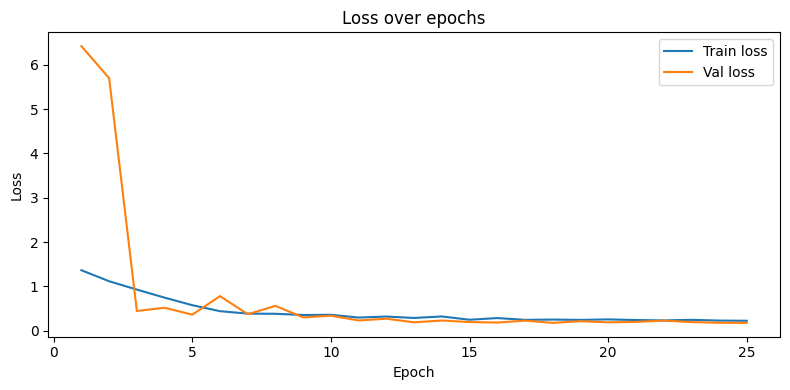

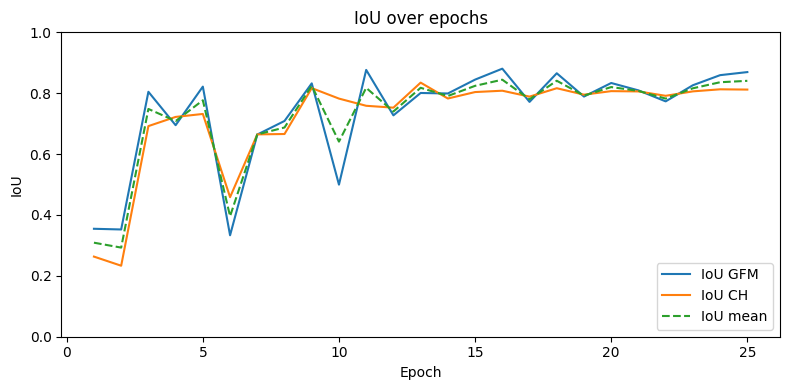

💾 Saved curves to /tmp/loss_curves.png and /tmp/iou_curves.png
🏁 Best @ epoch 16 | mean IoU=0.844 | Val loss=0.1812 | Model=/tmp/best_multilabel.pt


In [14]:
# === Train loop with AMP, IoU (per-class), threshold tuning, LR-on-IoU, early stop + CURVES ===
import torch, numpy as np, matplotlib.pyplot as plt
from contextlib import nullcontext
try:
    from torch.amp import autocast
except Exception:
    from torch.cuda.amp import autocast

assert 'device' in globals(), "device undefined."
assert 'model'  in globals(), "model undefined."
assert 'optimizer' in globals(), "optimizer undefined. Run the losses/optimizer cell first."
assert 'criterion' in globals(), "criterion undefined. Run the losses/optimizer cell first."
assert 'train_loader' in globals() and 'val_loader' in globals(), "missing loaders."
EPOCHS = int(globals().get('EPOCHS', 50))

# AMP/scaler guards
amp_dtype   = globals().get('amp_dtype', (torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16))
_use_scaler = 'scaler' in globals()
use_cuda    = (device.type == "cuda")

# ---------- IoU utilities (apply normalizer if defined) ----------
def _maybe_norm(x):
    if 'normalizer' in globals() and isinstance(normalizer, torch.nn.Module):
        return normalizer(x)
    return x

def iou_per_class_sigmoid(model, loader, device, thresholds=(0.5, 0.5), amp_dtype=None):
    """
    Returns np.array [IoU_GFM, IoU_CH] computed over loader.
    thresholds: per-class binarization thresholds for (GFM, CH).
    """
    model.eval()
    inter = torch.zeros(2, dtype=torch.double, device=device)
    uni   = torch.zeros(2, dtype=torch.double, device=device)

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device, non_blocking=True)
            imgs = _maybe_norm(imgs)
            gt2  = masks[:, :2].to(device, non_blocking=True)

            _amp = (amp_dtype if amp_dtype is not None
                    else (torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported())
                          else torch.float16))
            ctx = autocast('cuda', dtype=_amp) if device.type == "cuda" else nullcontext()
            with ctx:
                logits = model(imgs)
                probs  = torch.sigmoid(logits)[:, :2]

            preds = torch.stack([(probs[:, 0] > thresholds[0]).float(),
                                 (probs[:, 1] > thresholds[1]).float()], dim=1)

            inter += (preds * gt2).sum(dim=(0, 2, 3)).double()
            uni   += ((preds + gt2) > 0).sum(dim=(0, 2, 3)).double()

    iou = (inter / (uni + 1e-6)).detach().cpu().numpy()
    return iou  # [IoU_GFM, IoU_CH]

def _predict_probs_cpu(model, imgs, device, amp_dtype=None):
    _amp = (amp_dtype if amp_dtype is not None
            else (torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported())
                  else torch.float16))
    ctx = autocast('cuda', dtype=_amp) if device.type == "cuda" else nullcontext()
    model.eval()
    with torch.no_grad(), ctx:
        imgs = imgs.to(device, non_blocking=True)
        imgs = _maybe_norm(imgs)
        logits = model(imgs)
        probs  = torch.sigmoid(logits)[:, :2]
    return probs.detach().float().cpu()

@torch.no_grad()
def _cache_val_preds(model, loader, device, amp_dtype=None):
    cached = []
    for imgs, masks in loader:
        probs_cpu = _predict_probs_cpu(model, imgs, device, amp_dtype=amp_dtype)  # [B,2,H,W] CPU
        gt2_cpu   = masks[:, :2].float().cpu()
        cached.append((probs_cpu, gt2_cpu))
    return cached

def _tune_thresholds_from_cached(cached, coarse_grid=None, refine_step=0.01, refine_radius=0.10):
    import numpy as np
    if coarse_grid is None:
        coarse_grid = np.linspace(0.05, 0.95, 19)

    def eval_pair(tg, tc):
        inter = torch.zeros(2, dtype=torch.double)
        uni   = torch.zeros(2, dtype=torch.double)
        for probs_cpu, gt2_cpu in cached:
            preds = torch.stack([(probs_cpu[:,0] > tg).float(),
                                 (probs_cpu[:,1] > tc).float()], dim=1)
            inter += (preds * gt2_cpu).sum(dim=(0,2,3)).double()
            uni   += ((preds + gt2_cpu) > 0).sum(dim=(0,2,3)).double()
        iou = (inter / (uni + 1e-6)).numpy()
        return float(iou.mean()), iou

    best = {"mean": -1.0, "th_gfm": 0.5, "th_ch": 0.5, "iou": None}
    for tg in coarse_grid:
        for tc in coarse_grid:
            m, i = eval_pair(float(tg), float(tc))
            if m > best["mean"]:
                best = {"mean": m, "th_gfm": float(tg), "th_ch": float(tc), "iou": i}

    tg0, tc0 = best["th_gfm"], best["th_ch"]
    lo_tg, hi_tg = max(0.0, tg0 - refine_radius), min(1.0, tg0 + refine_radius)
    lo_tc, hi_tc = max(0.0, tc0 - refine_radius), min(1.0, tc0 + refine_radius)
    fine_g = np.arange(lo_tg, hi_tg + 1e-9, refine_step)
    fine_c = np.arange(lo_tc, hi_tc + 1e-9, refine_step)
    for tg in fine_g:
        for tc in fine_c:
            m, i = eval_pair(float(tg), float(tc))
            if m > best["mean"]:
                best = {"mean": m, "th_gfm": float(tg), "th_ch": float(tc), "iou": i}
    return best

# ---------- Training controls ----------
PATIENCE = int(globals().get('PATIENCE', 10))
AUTO_TUNE_THRESHOLDS = True
best_mean_iou = -1.0
wait = 0

# Reuse optimizer; redefine scheduler to step on IoU (max mode)
from torch import optim as _optim
scheduler = _optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# History buffers for plotting
history = {
    'epoch': [], 'train_loss': [], 'val_loss': [],
    'iou_gfm': [], 'iou_ch': [], 'iou_mean': [], 'lr': []
}

# ---------- Train loop ----------
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0

    for imgs, masks in train_loader:
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        imgs  = _maybe_norm(imgs)

        optimizer.zero_grad(set_to_none=True)
        if use_cuda and _use_scaler:
            with autocast('cuda', dtype=amp_dtype):
                logits = model(imgs)
                loss   = criterion(logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            loss   = criterion(logits, masks)
            loss.backward()
            optimizer.step()

        running += loss.item() * imgs.size(0)

    train_loss = running / max(1, len(train_loader.dataset))

    # Validation loss
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            imgs  = _maybe_norm(imgs)
            if use_cuda and _use_scaler:
                with autocast('cuda', dtype=amp_dtype):
                    v_logits = model(imgs)
                    v_loss   = criterion(v_logits, masks)
            else:
                v_logits = model(imgs)
                v_loss   = criterion(v_logits, masks)
            val_running += v_loss.item() * imgs.size(0)
    val_loss = val_running / max(1, len(val_loader.dataset))

    # IoU @ fixed thresholds 0.5/0.5
    iou = iou_per_class_sigmoid(model, val_loader, device, thresholds=(0.5, 0.5), amp_dtype=amp_dtype)
    mean_iou = float(iou.mean())

    lr_now = optimizer.param_groups[0]['lr']
    print(f"📘 Epoch {epoch}/{EPOCHS} | Train {train_loss:.4f} | Val {val_loss:.4f} "
          f"| IoU GFM {iou[0]:.3f} CH {iou[1]:.3f} | mean {mean_iou:.3f} | LR {lr_now:.2e}")

    # Step LR scheduler on IoU
    prev_lr = lr_now
    scheduler.step(mean_iou)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < prev_lr:
        print(f"🔻 LR reduced: {prev_lr:.2e} → {new_lr:.2e}")

    # Early stopping + checkpoint on best mean IoU
    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou
        wait = 0
        BEST_MODEL_PATH = "/tmp/best_multilabel.pt"
        torch.save(model.state_dict(), BEST_MODEL_PATH)

        globals().update({
            'BEST_MODEL_PATH': BEST_MODEL_PATH,
            'BEST_EPOCH': epoch,
            'BEST_VAL_LOSS': val_loss,
            'BEST_MEAN_IOU': best_mean_iou,
            'BEST_IOU_VAL': {'gfm': float(iou[0]), 'ch': float(iou[1])}
        })

        if AUTO_TUNE_THRESHOLDS:
            cached_val = _cache_val_preds(model, val_loader, device, amp_dtype=amp_dtype)
            best_thr = _tune_thresholds_from_cached(cached_val, coarse_grid=None, refine_step=0.01, refine_radius=0.10)
            globals().update({
                'best':   {'th_gfm': float(best_thr['th_gfm']),
                           'th_ch' : float(best_thr['th_ch']),
                           'iou'   : [float(best_thr['iou'][0]), float(best_thr['iou'][1])],
                           'mean'  : float(best_thr['mean'])},
                'TH_GFM': float(best_thr['th_gfm']),
                'TH_CH' : float(best_thr['th_ch'])
            })
            print(f"🎯 Tuned thresholds (VAL) -> GFM={best_thr['th_gfm']:.2f}, CH={best_thr['th_ch']:.2f} | "
                  f"IoUs: GFM={best_thr['iou'][0]:.3f}, CH={best_thr['iou'][1]:.3f}, mean={best_thr['mean']:.3f}")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⛔ Early stopping (mean IoU).")
            break

    # Log history
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['iou_gfm'].append(float(iou[0]))
    history['iou_ch'].append(float(iou[1]))
    history['iou_mean'].append(mean_iou)
    history['lr'].append(new_lr)

# ---------- Plot curves ----------
if len(history['epoch']) > 0:
    fig1 = plt.figure(figsize=(8,4))
    plt.plot(history['epoch'], history['train_loss'], label='Train loss')
    plt.plot(history['epoch'], history['val_loss'],   label='Val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over epochs'); plt.legend(); plt.tight_layout()
    plt.show()

    fig2 = plt.figure(figsize=(8,4))
    plt.plot(history['epoch'], history['iou_gfm'],  label='IoU GFM')
    plt.plot(history['epoch'], history['iou_ch'],   label='IoU CH')
    plt.plot(history['epoch'], history['iou_mean'], label='IoU mean', linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.ylim(0,1); plt.title('IoU over epochs'); plt.legend(); plt.tight_layout()
    plt.show()

    # Optional: save figures
    try:
        fig1.savefig('/tmp/loss_curves.png', dpi=150, bbox_inches='tight')
        fig2.savefig('/tmp/iou_curves.png',  dpi=150, bbox_inches='tight')
        print("💾 Saved curves to /tmp/loss_curves.png and /tmp/iou_curves.png")
    except Exception:
        pass

# Expose history for later cells
globals()['history'] = history
print(f"🏁 Best @ epoch {globals().get('BEST_EPOCH','-')} | mean IoU={globals().get('BEST_MEAN_IOU', -1):.3f} "
      f"| Val loss={globals().get('BEST_VAL_LOSS', float('inf')):.4f} | Model={globals().get('BEST_MODEL_PATH','-')}")





# 📊 Threshold Tuning, Evaluation & Visualization

This section provides a **condensed and self-contained pipeline** for evaluating the trained model on **validation (VAL)** and **test (TEST)** sets, using **optimized thresholds** for each class (GFM, CH).

## 🔑 Key steps

1. **Threshold Resolution**  
   - Thresholds are resolved in the following order of priority:  
     1. Global variables from training (`TH_GFM`, `TH_CH`)  
     2. JSON file (if previously saved)  
     3. Automatic tuning on the VAL set (coarse + refine grid search)  

   This ensures reproducibility and flexibility. The tuned thresholds can optionally be saved to JSON.

2. **Evaluation Metrics**  
   - For both **VAL** and **TEST**, the pipeline computes:  
     - IoU (per-class and mean)  
     - Precision, Recall, F1/Dice, Specificity  
     - Confusion matrix counts (TP, FP, FN, TN)  
     - Percentage of predicted pixels per class  
   - Results are reported as:
     - **Summary (micro-averaged)** for GFM, CH, and mean IoU  
     - **Per-image tables** with detailed metrics  

3. **Visualizations**  
   - **Per-sample overlays** (3 examples per loader):
     - Original grayscale image
     - Ground truth masks (GT)
     - Predicted masks (Pred)
     - Error map (TP = green, FP = red, FN = blue)  
   - **Single-class grids (2x3)**:
     - Top row: CH (red overlay)
     - Bottom row: GFM (green overlay)

4. **Device Safety**  
   - All probability computations are done on **CPU** after forward pass with AMP (if CUDA available).  
   - This avoids device mismatch issues and speeds up evaluation.

## 📝 Output
- Console summaries for VAL and TEST sets  
- Pandas tables per image (IoU, Dice, precision, recall, etc.)  
- Matplotlib figures for overlays and grids  

This block replaces the previous scattered threshold/evaluation code, ensuring a **clean, reproducible, and extendable** evaluation stage.



Using thresholds from globals -> GFM=0.01, CH=0.77

=== VAL SUMMARY ===
GFM: IoU=0.912, F1/Dice=0.954, P=0.968, R=0.940, pred%=34.16% | TP=173425 FP=5678 FN=11071 TN=334114
CH : IoU=0.840, F1/Dice=0.913, P=0.897, R=0.929, pred%=23.95% | TP=112652 FP=12920 FN=8587 TN=390129
MEAN IoU: 0.876

VAL — per-image table: GFM


image  total_px  pred_px  pred_pct      TP    FP  \
0  AC_UT_G_04_01_UO_200X_0003.png    262144    20024      7.64   17329  2695   
1  AC_UT_G_04_01_UO_200X_0010.png    262144   159079     60.68  156096  2983   

     FN      TN  precision  recall  F1/Dice     IoU  specificity  
0  1785  240335     0.8654  0.9066   0.8855  0.7946       0.9889  
1  9286   93779     0.9812  0.9439   0.9622  0.9271       0.9692


VAL — per-image table: Carbonhole


image  total_px  pred_px  pred_pct     TP    FP  \
0  AC_UT_G_04_01_UO_200X_0003.png    262144    85456      32.6  81059  4397   
1  AC_UT_G_04_01_UO_200X_0010.png    262144    40116      15.3  31593  8523   

     FN      TN  precision  recall  F1/Dice     IoU  specificity  
0  3466  173222     0.9485  0.9590   0.9537  0.9116       0.9752  
1  5121  216907     0.7875  0.8605   0.8224  0.6984       0.9622


=== TEST SUMMARY ===
GFM: IoU=0.763, F1/Dice=0.865, P=0.901, R=0.833, pred%=20.44% | TP=48244 FP=5328 FN=9675 TN=198897
CH : IoU=0.797, F1/Dice=0.887, P=0.919, R=0.857, pred%=16.55% | TP=39871 FP=3502 FN=6646 TN=212125
MEAN IoU: 0.780

TEST — per-image table: GFM


image  total_px  pred_px  pred_pct     TP    FP  \
0  2AC_UT_GO_02_01_2000X_0003.png    262144    53572     20.44  48244  5328   

     FN      TN  precision  recall  F1/Dice     IoU  specificity  
0  9675  198897     0.9005   0.833   0.8654  0.7628       0.9739


TEST — per-image table: Carbonhole


image  total_px  pred_px  pred_pct     TP    FP  \
0  2AC_UT_GO_02_01_2000X_0003.png    262144    43373     16.55  39871  3502   

     FN      TN  precision  recall  F1/Dice     IoU  specificity  
0  6646  212125     0.9193  0.8571   0.8871  0.7971       0.9838


VAL: per-sample overlays


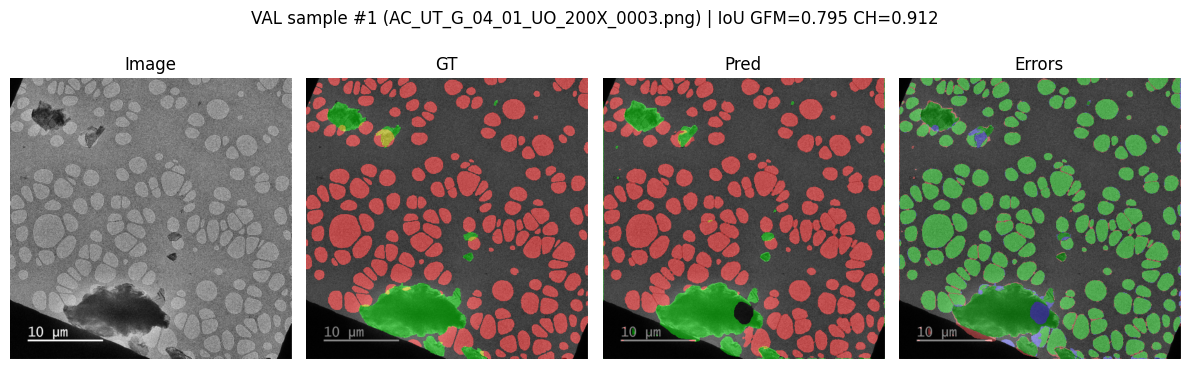

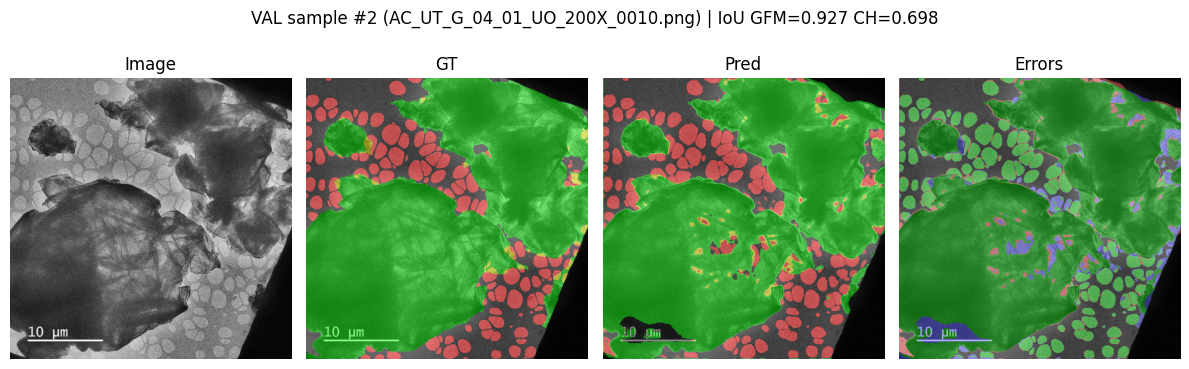

TEST: per-sample overlays


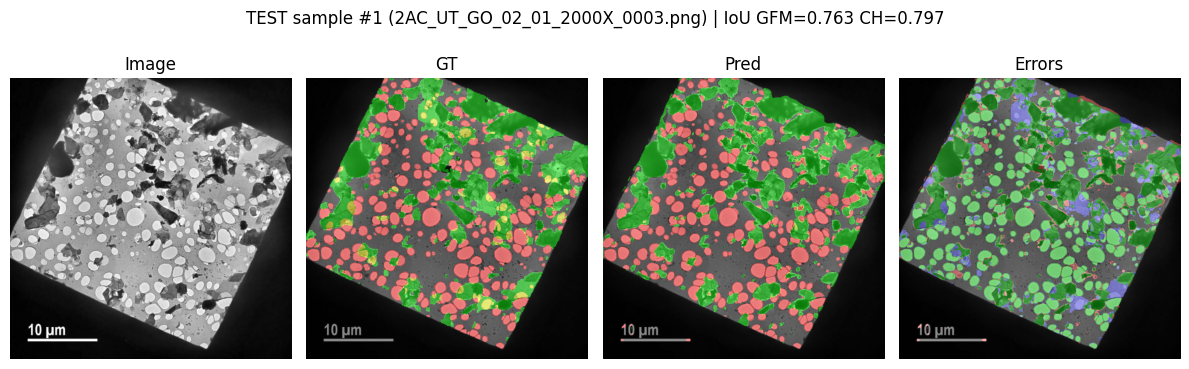


VAL: single-class grids


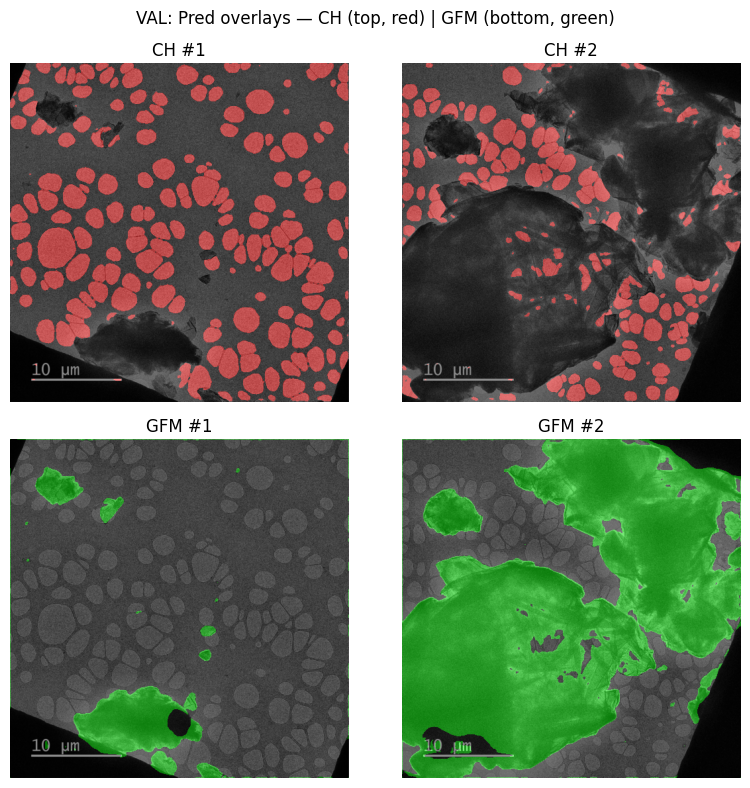

TEST: single-class grids


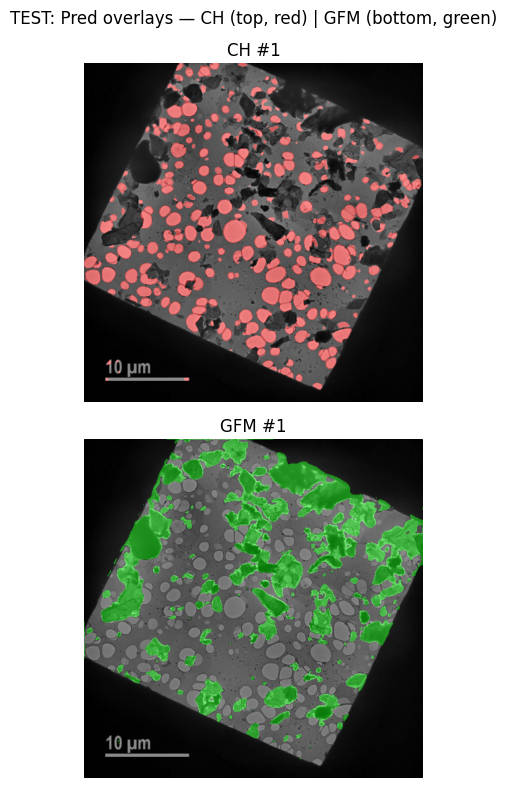

In [15]:
# === THRESHOLDS + EVALUATION + VISUALIZATION (condensed, self-contained) ===
import os, json, math
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from contextlib import nullcontext
try:
    from torch.amp import autocast
except Exception:
    from torch.cuda.amp import autocast

# --- prerequisites ---
assert 'device' in globals(), "device undefined."
assert 'model'  in globals(), "model undefined."
assert 'val_loader' in globals() and 'test_loader' in globals(), "val_loader/test_loader undefined."

# Optional paths (JSON persistence)
THRESH_FILE = globals().get('THRESH_FILE', "/tmp/best_thresholds.json")
GCS_THRESH_PATH = None
try:
    if 'MODEL_OUTPUT_DIR' in globals() and MODEL_OUTPUT_DIR:
        GCS_THRESH_PATH = MODEL_OUTPUT_DIR.rstrip('/') + "/best_thresholds.json"
except Exception:
    GCS_THRESH_PATH = None

# ========== Helpers: normalization, AMP context, names ==========
def _maybe_norm(x: torch.Tensor) -> torch.Tensor:
    if 'normalizer' in globals() and isinstance(normalizer, torch.nn.Module):
        return normalizer(x)
    return x

def _amp_dtype_default():
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
        return torch.bfloat16
    return torch.float16

def _batch_names(loader, n):
    names = [f"sample_{i+1}" for i in range(n)]
    try:
        base = loader.dataset
        if hasattr(base, "dataset") and hasattr(base, "indices"):  # Subset
            ds = base.dataset
            idxs = base.indices[:n]
            names = [os.path.basename(ds.image_paths[i]) for i in idxs]
        elif hasattr(base, "image_paths"):
            names = [os.path.basename(p) for p in base.image_paths[:n]]
    except Exception:
        pass
    return names

# ========== Forward → probs on CPU ==========
def _predict_probs_cpu(model, imgs, device, amp_dtype=None):
    amp_dtype = amp_dtype or globals().get('amp_dtype', _amp_dtype_default())
    ctx = autocast('cuda', dtype=amp_dtype) if device.type == "cuda" else nullcontext()
    model.eval()
    with torch.no_grad(), ctx:
        imgs = imgs.to(device, non_blocking=True)
        imgs = _maybe_norm(imgs)
        logits = model(imgs)
        probs  = torch.sigmoid(logits)[:, :2]        # use first 2 channels (GFM, CH)
    return probs.detach().float().cpu()              # [B,2,H,W] on CPU

# ========== Metrics ==========
def _counts_for_class(p, t):
    """p,t: [H,W] 0/1 (CPU tensors or numpy)"""
    if isinstance(p, np.ndarray): p = torch.from_numpy(p)
    if isinstance(t, np.ndarray): t = torch.from_numpy(t)
    p = (p>0.5); t=(t>0.5)
    tp = int((p & t).sum().item())
    fp = int((p & (~t)).sum().item())
    fn = int(((~p) & t).sum().item())
    tn = int(((~p) & (~t)).sum().item())
    return tp, fp, fn, tn

def _metrics_from_counts(tp, fp, fn, tn):
    eps = 1e-6
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = (2*tp) / (2*tp + fp + fn + eps)  # Dice for binary
    iou  = tp / (tp + fp + fn + eps)
    spec = tn / (tn + fp + eps)
    return dict(precision=prec, recall=rec, f1=f1, dice=f1, iou=iou, specificity=spec)

# ========== Threshold tuning on VAL (coarse + refine; CPU pipeline) ==========
@torch.no_grad()
def tune_thresholds_on_val(model, loader, device, coarse_grid=None, refine_step=0.01, refine_radius=0.10, amp_dtype=None):
    import numpy as np
    if coarse_grid is None:
        coarse_grid = np.linspace(0.05, 0.95, 19)

    # precompute once
    cached = []
    for imgs, masks in loader:
        probs_cpu = _predict_probs_cpu(model, imgs, device, amp_dtype=amp_dtype)
        gt2_cpu   = masks[:, :2].float().cpu()
        cached.append((probs_cpu, gt2_cpu))

    def eval_pair(tg, tc):
        inter = torch.zeros(2, dtype=torch.double)
        uni   = torch.zeros(2, dtype=torch.double)
        for probs_cpu, gt2_cpu in cached:
            preds = torch.stack([(probs_cpu[:,0] > tg).float(),
                                 (probs_cpu[:,1] > tc).float()], dim=1)
            inter += (preds * gt2_cpu).sum(dim=(0,2,3)).double()
            uni   += ((preds + gt2_cpu) > 0).sum(dim=(0,2,3)).double()
        iou = (inter / (uni + 1e-6)).numpy()
        return float(iou.mean()), iou

    best = {"mean": -1.0, "th_gfm": 0.5, "th_ch": 0.5, "iou": None}
    # coarse
    for tg in coarse_grid:
        for tc in coarse_grid:
            m, i = eval_pair(float(tg), float(tc))
            if m > best["mean"]:
                best = {"mean": m, "th_gfm": float(tg), "th_ch": float(tc), "iou": i}
    # refine
    tg0, tc0 = best["th_gfm"], best["th_ch"]
    lo_tg, hi_tg = max(0.0, tg0 - refine_radius), min(1.0, tg0 + refine_radius)
    lo_tc, hi_tc = max(0.0, tc0 - refine_radius), min(1.0, tc0 + refine_radius)
    fine_g = np.arange(lo_tg, hi_tg + 1e-9, refine_step)
    fine_c = np.arange(lo_tc, hi_tc + 1e-9, refine_step)
    for tg in fine_g:
        for tc in fine_c:
            m, i = eval_pair(float(tg), float(tc))
            if m > best["mean"]:
                best = {"mean": m, "th_gfm": float(tg), "th_ch": float(tc), "iou": i}
    return best

# ========== Persistence ==========
def save_thresholds(th_dict, local_path=THRESH_FILE, gcs_path=GCS_THRESH_PATH):
    try:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        with open(local_path, "w") as f:
            json.dump(th_dict, f, indent=2)
        print(f"💾 Saved thresholds to {local_path}: {th_dict}")
    except Exception as e:
        print(f"⚠️ Could not save to {local_path}: {e}")
    if gcs_path and 'fs' in globals():
        try:
            with fs.open(gcs_path, "wb") as f:
                f.write(json.dumps(th_dict, indent=2).encode("utf-8"))
            print(f"☁️  Also saved to GCS: {gcs_path}")
        except Exception as e:
            print(f"⚠️ Could not save to GCS ({gcs_path}): {e}")

def load_thresholds(local_path=THRESH_FILE):
    try:
        with open(local_path, "r") as f:
            return json.load(f)
    except Exception:
        return None

# ========== Resolve thresholds (globals → JSON → tune now) ==========
def resolve_thresholds(model, val_loader, device, prefer_globals=True, force_retune=False, save_json=False, amp_dtype=None):
    tg = tc = None; src = "default(0.5,0.5)"
    if prefer_globals and ('TH_GFM' in globals()) and ('TH_CH' in globals()) and not force_retune:
        tg, tc, src = float(TH_GFM), float(TH_CH), "globals"
    elif not force_retune:
        d = load_thresholds(THRESH_FILE)
        if d and ('th_gfm' in d) and ('th_ch' in d):
            tg, tc, src = float(d['th_gfm']), float(d['th_ch']), f"json:{THRESH_FILE}"
    if tg is None or tc is None or force_retune:
        print("No usable thresholds → tuning on VAL...")
        tuned = tune_thresholds_on_val(model, val_loader, device, amp_dtype=amp_dtype)
        tg, tc = float(tuned['th_gfm']), float(tuned['th_ch'])
        if save_json:
            save_thresholds({"th_gfm": tg, "th_ch": tc})
        globals().update({'TH_GFM': tg, 'TH_CH': tc, 'best': tuned})
        src = "tuned_now"
    return tg, tc, src

# ========== Evaluation (IoU + table per image + summary) ==========
@torch.no_grad()
def evaluate_with_thresholds(model, loader, device, th_gfm, th_ch, title="VAL", amp_dtype=None):
    names_all = []
    # try to build names list aligned with iteration order
    try:
        ds = loader.dataset
        if hasattr(ds, "indices") and hasattr(ds, "dataset"):  # Subset
            base = ds.dataset
            names_all = [os.path.basename(base.image_paths[i]) for i in ds.indices]
        elif hasattr(ds, "image_paths"):
            names_all = [os.path.basename(p) for p in ds.image_paths]
    except Exception:
        names_all = [f"sample_{i+1}" for i in range(len(loader.dataset))]

    rows_g, rows_c = [], []
    totals = { "GFM": dict(tp=0, fp=0, fn=0, tn=0, pred_px=0, total_px=0),
               "CH":  dict(tp=0, fp=0, fn=0, tn=0, pred_px=0, total_px=0) }
    idx = 0

    for imgs, masks in loader:
        probs = _predict_probs_cpu(model, imgs, device, amp_dtype=amp_dtype)  # [B,2,H,W] CPU
        B, _, H, W = probs.shape
        gt2 = masks[:, :2].float().cpu()
        pred_g = (probs[:, 0] > th_gfm).float()
        pred_c = (probs[:, 1] > th_ch ).float()
        total_px = int(H * W)

        for b in range(B):
            name = names_all[idx] if idx < len(names_all) else f"sample_{idx+1}"
            idx += 1

            # GFM
            p, t = pred_g[b], gt2[b, 0]
            tp, fp, fn, tn = _counts_for_class(p, t)
            pred_px = int((p == 1).sum().item())
            met = _metrics_from_counts(tp, fp, fn, tn)
            rows_g.append({
                "image": name, "total_px": total_px, "pred_px": pred_px,
                "pred_pct": round(100.0 * pred_px / total_px, 2),
                "TP": tp, "FP": fp, "FN": fn, "TN": tn,
                "precision": round(met["precision"], 4),
                "recall":    round(met["recall"], 4),
                "F1/Dice":   round(met["f1"], 4),
                "IoU":       round(met["iou"], 4),
                "specificity": round(met["specificity"], 4)
            })
            T = totals["GFM"]; T["tp"]+=tp; T["fp"]+=fp; T["fn"]+=fn; T["tn"]+=tn; T["pred_px"]+=pred_px; T["total_px"]+=total_px

            # CH
            p, t = pred_c[b], gt2[b, 1]
            tp, fp, fn, tn = _counts_for_class(p, t)
            pred_px = int((p == 1).sum().item())
            met = _metrics_from_counts(tp, fp, fn, tn)
            rows_c.append({
                "image": name, "total_px": total_px, "pred_px": pred_px,
                "pred_pct": round(100.0 * pred_px / total_px, 2),
                "TP": tp, "FP": fp, "FN": fn, "TN": tn,
                "precision": round(met["precision"], 4),
                "recall":    round(met["recall"], 4),
                "F1/Dice":   round(met["f1"], 4),
                "IoU":       round(met["iou"], 4),
                "specificity": round(met["specificity"], 4)
            })
            T = totals["CH"]; T["tp"]+=tp; T["fp"]+=fp; T["fn"]+=fn; T["tn"]+=tn; T["pred_px"]+=pred_px; T["total_px"]+=total_px

    df_gfm = pd.DataFrame(rows_g)
    df_ch  = pd.DataFrame(rows_c)

    def agg(T):
        tp, fp, fn, tn = T["tp"], T["fp"], T["fn"], T["tn"]
        met = _metrics_from_counts(tp, fp, fn, tn)
        return dict(
            total_images=len(df_gfm),
            total_px=T["total_px"],
            pred_px=T["pred_px"],
            pred_pct=100.0 * (T["pred_px"] / (T["total_px"] + 1e-6)),
            TP=tp, FP=fp, FN=fn, TN=tn,
            precision=met["precision"], recall=met["recall"], f1=met["f1"],
            dice=met["dice"], iou=met["iou"], specificity=met["specificity"]
        )

    sum_g = agg(totals["GFM"])
    sum_c = agg(totals["CH"])
    mean_iou = (sum_g["iou"] + sum_c["iou"]) / 2.0

    print(f"\n=== {title} SUMMARY ===")
    print(f"GFM: IoU={sum_g['iou']:.3f}, F1/Dice={sum_g['dice']:.3f}, P={sum_g['precision']:.3f}, R={sum_g['recall']:.3f}, "
          f"pred%={sum_g['pred_pct']:.2f}% | TP={sum_g['TP']} FP={sum_g['FP']} FN={sum_g['FN']} TN={sum_g['TN']}")
    print(f"CH : IoU={sum_c['iou']:.3f}, F1/Dice={sum_c['dice']:.3f}, P={sum_c['precision']:.3f}, R={sum_c['recall']:.3f}, "
          f"pred%={sum_c['pred_pct']:.2f}% | TP={sum_c['TP']} FP={sum_c['FP']} FN={sum_c['FN']} TN={sum_c['TN']}")
    print(f"MEAN IoU: {mean_iou:.3f}")

    try:
        from IPython.display import display
        print(f"\n{title} — per-image table: GFM"); display(df_gfm)
        print(f"\n{title} — per-image table: Carbonhole"); display(df_ch)
    except Exception:
        print(f"\n{title} — per-image table: GFM"); print(df_gfm.to_string(index=False))
        print(f"\n{title} — per-image table: Carbonhole"); print(df_ch.to_string(index=False))

    return dict(summary=dict(GFM=sum_g, CH=sum_c, mean_iou=mean_iou), df_gfm=df_gfm, df_ch=df_ch)

# ========== Visualization ==========
def _overlay_from_2ch(mask2: np.ndarray) -> np.ndarray:
    gfm = mask2[0] > 0.5; ch = mask2[1] > 0.5
    H, W = gfm.shape; rgb = np.zeros((H, W, 3), dtype=np.uint8)
    both = gfm & ch
    rgb[both] = [255, 255, 0]
    rgb[gfm & ~ch] = [0, 255, 0]
    rgb[ch  & ~gfm] = [255, 0, 0]
    return rgb

def _error_map(gt2: np.ndarray, pr2: np.ndarray) -> np.ndarray:
    H, W = gt2.shape[1:]
    tp = ((gt2 == 1) & (pr2 == 1)).any(axis=0)
    fn = ((gt2 == 1) & (pr2 == 0)).any(axis=0)
    fp = ((gt2 == 0) & (pr2 == 1)).any(axis=0)
    rgb = np.zeros((H, W, 3), dtype=np.uint8)
    rgb[tp] = [0, 200, 0]; rgb[fp] = [255, 80, 80]; rgb[fn] = [80, 80, 255]
    return rgb

def visualize_per_sample(loader, th_gfm, th_ch, num_samples=3, title_prefix="VAL"):
    with torch.no_grad():
        imgs, masks = next(iter(loader))
        k = min(num_samples, imgs.size(0))
        names = _batch_names(loader, k)
        probs = _predict_probs_cpu(model, imgs[:k], device)  # [k,2,H,W] CPU
        preds = torch.stack([(probs[:,0] > th_gfm).float(),
                             (probs[:,1] > th_ch ).float()], dim=1).numpy()

        for i in range(k):
            img  = imgs[i, 0].cpu().numpy()
            gt_i = masks[i, :2].cpu().numpy()
            pr_i = preds[i]

            gt_rgb = _overlay_from_2ch(gt_i)
            pr_rgb = _overlay_from_2ch(pr_i)
            err    = _error_map(gt_i, pr_i)

            # per-image IoU
            def _iou_one(g, p):
                inter = (g & p).sum(); uni = (g | p).sum()
                return float(inter / (uni + 1e-6)) if uni > 0 else 1.0
            iou_g = _iou_one(gt_i[0]>0.5, pr_i[0]>0.5)
            iou_c = _iou_one(gt_i[1]>0.5, pr_i[1]>0.5)

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{title_prefix} sample #{i+1} ({names[i]}) | IoU GFM={iou_g:.3f} CH={iou_c:.3f}")
            plt.subplot(1,4,1); plt.imshow(img, cmap='gray'); plt.title("Image"); plt.axis('off')
            plt.subplot(1,4,2); plt.imshow(img, cmap='gray'); plt.imshow(gt_rgb, alpha=0.45); plt.title("GT");   plt.axis('off')
            plt.subplot(1,4,3); plt.imshow(img, cmap='gray'); plt.imshow(pr_rgb, alpha=0.45); plt.title("Pred"); plt.axis('off')
            plt.subplot(1,4,4); plt.imshow(img, cmap='gray'); plt.imshow(err,   alpha=0.45); plt.title("Errors");plt.axis('off')
            plt.tight_layout(); plt.show()

def visualize_single_class_grid(loader, th_gfm, th_ch, num_cols=3, title_prefix="VAL"):
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        n = min(num_cols, imgs.size(0))
        probs = _predict_probs_cpu(model, imgs[:n], device)  # [n,2,H,W] CPU
        pred_gfm = (probs[:, 0] > th_gfm).float().numpy()
        pred_ch  = (probs[:, 1] > th_ch ).float().numpy()
        imgs_np  = imgs[:n, 0].cpu().numpy()

        fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
        fig.suptitle(f"{title_prefix}: Pred overlays — CH (top, red) | GFM (bottom, green)")
        for i in range(n):
            img = imgs_np[i]
            ov_ch  = np.zeros((*img.shape, 3), dtype=np.uint8);  ov_ch[pred_ch[i] > 0.5]  = [255, 0, 0]
            ov_gfm = np.zeros((*img.shape, 3), dtype=np.uint8);  ov_gfm[pred_gfm[i] > 0.5]= [0, 255, 0]

            ax = axes[0, i] if n > 1 else axes[0]
            ax.imshow(img, cmap='gray'); ax.imshow(ov_ch,  alpha=0.45); ax.set_title(f"CH #{i+1}");  ax.axis('off')
            ax = axes[1, i] if n > 1 else axes[1]
            ax.imshow(img, cmap='gray'); ax.imshow(ov_gfm, alpha=0.45); ax.set_title(f"GFM #{i+1}"); ax.axis('off')
        plt.tight_layout(); plt.show()

# ========== RUN: resolve thresholds → evaluate VAL & TEST → visualize ==========
TH_GFM, TH_CH, src = resolve_thresholds(
    model, val_loader, device,
    prefer_globals=True, force_retune=False, save_json=False,
    amp_dtype=globals().get('amp_dtype', None)
)
print(f"Using thresholds from {src} -> GFM={TH_GFM:.2f}, CH={TH_CH:.2f}")

val_res  = evaluate_with_thresholds(model, val_loader,  device, TH_GFM, TH_CH, title="VAL",  amp_dtype=globals().get('amp_dtype', None))
test_res = evaluate_with_thresholds(model, test_loader, device, TH_GFM, TH_CH, title="TEST", amp_dtype=globals().get('amp_dtype', None))

print("\nVAL: per-sample overlays");  visualize_per_sample(val_loader,  TH_GFM, TH_CH, num_samples=3, title_prefix="VAL")
print("TEST: per-sample overlays");   visualize_per_sample(test_loader, TH_GFM, TH_CH, num_samples=3, title_prefix="TEST")

print("\nVAL: single-class grids");   visualize_single_class_grid(val_loader,  TH_GFM, TH_CH, num_cols=3, title_prefix="VAL")
print("TEST: single-class grids");    visualize_single_class_grid(test_loader, TH_GFM, TH_CH, num_cols=3, title_prefix="TEST")
